In [ ]:
!pip install datasets transformers pytorch-fid scikit-image lpips torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.6 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import json
from datetime import datetime

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cpu


In [ ]:
# Configuration parameters
IMAGE_SIZE = 64
BATCH_SIZE = 64
NUM_WORKERS = 2
HIDDEN_DIMS = [64, 128, 256]
LATENT_DIM = 256
NUM_EMBEDDINGS = 512
NUM_RES_BLOCKS = 2
NUM_EPOCHS = 250
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
COMMITMENT_COST = 0.25
EMA_DECAY = 0.99
GRADIENT_CLIP = 1.0
CHECKPOINT_INTERVAL = 25
SCHEDULER_ETA_MIN = 1e-6  # <-- This was missing
SAVE_DIR = "./checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
class EmojiDataset(Dataset):
    def __init__(self, hf_dataset, image_size=64, augment=True):
        self.dataset = hf_dataset
        self.image_size = image_size
        self.augment = augment

        if augment:
            self.transform = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return self.transform(image)

In [ ]:
# Load dataset
print("Loading dataset...")
dataset = load_dataset("valhalla/emoji-dataset", split="train")
print(f"Dataset size: {len(dataset)} images")

# Create train/val split (90/10)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = EmojiDataset(
    dataset.select(range(train_size)),
    IMAGE_SIZE,
    augment=True
)
val_dataset = EmojiDataset(
    dataset.select(range(train_size, len(dataset))),
    IMAGE_SIZE,
    augment=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Dataset size: 2749 images
Train batches: 39, Val batches: 5


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.norm2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return F.relu(x + residual)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.out = nn.Conv2d(channels, channels, 1)
        self.scale = channels ** -0.5

    def forward(self, x):
        b, c, h, w = x.shape
        norm_x = self.norm(x)

        q = self.q(norm_x).view(b, c, -1).transpose(1, 2)
        k = self.k(norm_x).view(b, c, -1)
        v = self.v(norm_x).view(b, c, -1).transpose(1, 2)

        attn = torch.bmm(q, k) * self.scale
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(attn, v).transpose(1, 2).view(b, c, h, w)
        return x + self.out(out)

In [ ]:
class ImprovedEncoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=[64, 128, 256],
                 latent_dim=256, num_res_blocks=2, use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        modules = []

        # Initial convolution
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))

        # Downsampling blocks
        for i in range(len(hidden_dims)-1):
            # Add residual blocks
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i]))

            # Add attention at certain resolutions
            if use_attention and i == len(hidden_dims) - 2:
                modules.append(AttentionBlock(hidden_dims[i]))

            # Downsample
            modules.append(nn.Sequential(
                nn.Conv2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))

        # Final residual blocks
        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[-1]))

        # Project to latent
        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1], latent_dim, 1),
            nn.BatchNorm2d(latent_dim)
        ))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.encoder(x)

class ImprovedDecoder(nn.Module):
    def __init__(self, latent_dim=256, hidden_dims=[256, 128, 64],
                 out_channels=3, num_res_blocks=2, use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        modules = []

        # Initial projection
        modules.append(nn.Sequential(
            nn.Conv2d(latent_dim, hidden_dims[0], 1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))

        # Initial residual blocks
        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[0]))

        # Add attention
        if use_attention:
            modules.append(AttentionBlock(hidden_dims[0]))

        # Upsampling blocks
        for i in range(len(hidden_dims)-1):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))

            # Add residual blocks
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i+1]))

        # Final convolution
        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1], out_channels, 3, padding=1),
            nn.Sigmoid()
        ))

        self.decoder = nn.Sequential(*modules)

    def forward(self, z):
        return self.decoder(z)

In [ ]:
class ImprovedVectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25,
                 decay=0.99, epsilon=1e-5):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        # Initialize embeddings
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

        # EMA parameters
        self.register_buffer('cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('embed_avg', self.embeddings.weight.data.clone())
        self.register_buffer('usage_count', torch.zeros(num_embeddings))

    def forward(self, z):
        # Convert to [B, H, W, C]
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.embedding_dim)

        # Compute distances
        distances = (z_flattened.pow(2).sum(1, keepdim=True)
                    - 2 * z_flattened @ self.embeddings.weight.t()
                    + self.embeddings.weight.pow(2).sum(1, keepdim=True).t())

        # Get encoding indices
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize
        quantized = torch.matmul(encodings, self.embeddings.weight).view(z.shape)

        # Update EMA
        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(
                encodings.sum(0), alpha=1 - self.decay
            )
            embed_sum = encodings.t() @ z_flattened
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)

            # Laplace smoothing
            n = self.cluster_size.sum()
            cluster_size = ((self.cluster_size + self.epsilon)
                          / (n + self.num_embeddings * self.epsilon) * n)
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embeddings.weight.data.copy_(embed_normalized)

            # Track usage
            unique_indices = torch.unique(encoding_indices)
            self.usage_count.index_add_(0, unique_indices,
                                       torch.ones_like(unique_indices, dtype=torch.float))

        # Compute loss
        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator
        quantized = z + (quantized - z).detach()

        # Calculate perplexity
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Convert back to [B, C, H, W]
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        return quantized, loss, encoding_indices.view(z.shape[0], -1), perplexity

    def reset_unused_codes(self, threshold=0.01):
        usage_freq = self.usage_count / (self.usage_count.sum() + 1e-10)
        unused_indices = torch.where(usage_freq < threshold)[0]

        if len(unused_indices) > 0:
            used_indices = torch.where(usage_freq >= threshold)[0]
            if len(used_indices) > 0:
                random_indices = used_indices[torch.randint(0, len(used_indices),
                                                           (len(unused_indices),))]
                noise = torch.randn_like(self.embeddings.weight.data[random_indices]) * 0.1
                self.embeddings.weight.data[unused_indices] = (
                    self.embeddings.weight.data[random_indices] + noise
                )
                self.cluster_size.data[unused_indices] = self.cluster_size.data[random_indices]
                self.embed_avg.data[unused_indices] = self.embed_avg.data[random_indices]

            print(f"Reset {len(unused_indices)} unused codes")

        self.usage_count.zero_()

In [ ]:
class ImprovedVQVAE(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=[64, 128, 256],
                 latent_dim=256, num_embeddings=512, commitment_cost=0.25,
                 num_res_blocks=2, decay=0.99, use_attention=True):
        super().__init__()

        self.encoder = ImprovedEncoder(
            in_channels, hidden_dims, latent_dim,
            num_res_blocks, use_attention
        )
        self.vq = ImprovedVectorQuantizer(
            num_embeddings, latent_dim,
            commitment_cost, decay
        )
        self.decoder = ImprovedDecoder(
            latent_dim, list(reversed(hidden_dims)),
            in_channels, num_res_blocks, use_attention
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, indices, perplexity = self.vq(z)
        reconstructed = self.decoder(quantized)
        return reconstructed, vq_loss, indices, perplexity

# Create model
model = ImprovedVQVAE(
    in_channels=3,
    hidden_dims=HIDDEN_DIMS,
    latent_dim=LATENT_DIM,
    num_embeddings=NUM_EMBEDDINGS,
    commitment_cost=COMMITMENT_COST,
    num_res_blocks=NUM_RES_BLOCKS,
    decay=EMA_DECAY,
    use_attention=True
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

Model parameters: 8,113,667


In [ ]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_vq_loss = 0
    total_perplexity = 0

    for batch in tqdm(loader, desc="Training"):
        batch = batch.to(device)

        optimizer.zero_grad()
        reconstructed, vq_loss, _, perplexity = model(batch)
        recon_loss = F.mse_loss(reconstructed, batch)
        loss = recon_loss + vq_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_vq_loss += vq_loss.item()
        total_perplexity += perplexity.item()

    n_batches = len(loader)
    return (total_loss / n_batches,
            total_recon_loss / n_batches,
            total_vq_loss / n_batches,
            total_perplexity / n_batches)

def validate(model, loader, device):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_vq_loss = 0
    total_perplexity = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            batch = batch.to(device)
            reconstructed, vq_loss, _, perplexity = model(batch)
            recon_loss = F.mse_loss(reconstructed, batch)
            loss = recon_loss + vq_loss

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_vq_loss += vq_loss.item()
            total_perplexity += perplexity.item()

    n_batches = len(loader)
    return (total_loss / n_batches,
            total_recon_loss / n_batches,
            total_vq_loss / n_batches,
            total_perplexity / n_batches)

In [ ]:
# Initialize optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,
    eta_min=SCHEDULER_ETA_MIN
)

# Training metrics storage
train_losses = []
val_losses = []
perplexities = []
best_val_loss = float('inf')

# Training loop
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_recon, train_vq, train_perp = train_epoch(
        model, train_loader, optimizer, device
    )
    train_losses.append(train_loss)
    perplexities.append(train_perp)

    # Validate
    val_loss, val_recon, val_vq, val_perp = validate(
        model, val_loader, device
    )
    val_losses.append(val_loss)

    # Update scheduler
    scheduler.step()

    # Print metrics
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train - Loss: {train_loss:.4f} | Recon: {train_recon:.4f} | VQ: {train_vq:.4f} | Perp: {train_perp:.1f}")
    print(f"Val   - Loss: {val_loss:.4f} | Recon: {val_recon:.4f} | VQ: {val_vq:.4f} | Perp: {val_perp:.1f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'vqvae_best.pt'))
        print(f"→ New best model saved (val_loss: {val_loss:.4f})")

    # Periodic checkpoint
    if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, f'vqvae_epoch_{epoch+1}.pt'))

    # Reset unused codes
    if (epoch + 1) % 10 == 0:
        model.vq.reset_unused_codes(0.01)

# Save final model
torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'vqvae_final.pt'))
print("\n✅ Training complete!")

Starting training...


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]



Epoch 1/250
Train - Loss: 0.2263 | Recon: 0.0479 | VQ: 0.1784 | Perp: 54.8
Val   - Loss: 0.0859 | Recon: 0.0298 | VQ: 0.0561 | Perp: 28.2
→ New best model saved (val_loss: 0.0859)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]



Epoch 2/250
Train - Loss: 0.0560 | Recon: 0.0198 | VQ: 0.0361 | Perp: 33.5
Val   - Loss: 0.0509 | Recon: 0.0180 | VQ: 0.0329 | Perp: 30.1
→ New best model saved (val_loss: 0.0509)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]



Epoch 3/250
Train - Loss: 0.0464 | Recon: 0.0154 | VQ: 0.0311 | Perp: 34.5
Val   - Loss: 0.0444 | Recon: 0.0166 | VQ: 0.0278 | Perp: 30.7
→ New best model saved (val_loss: 0.0444)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]



Epoch 4/250
Train - Loss: 0.0417 | Recon: 0.0136 | VQ: 0.0281 | Perp: 34.8
Val   - Loss: 0.0373 | Recon: 0.0128 | VQ: 0.0245 | Perp: 30.5
→ New best model saved (val_loss: 0.0373)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 5/250
Train - Loss: 0.0361 | Recon: 0.0121 | VQ: 0.0240 | Perp: 35.3
Val   - Loss: 0.0349 | Recon: 0.0124 | VQ: 0.0225 | Perp: 32.6
→ New best model saved (val_loss: 0.0349)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 6/250
Train - Loss: 0.0348 | Recon: 0.0112 | VQ: 0.0237 | Perp: 35.7
Val   - Loss: 0.0378 | Recon: 0.0115 | VQ: 0.0263 | Perp: 32.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 7/250
Train - Loss: 0.0342 | Recon: 0.0106 | VQ: 0.0236 | Perp: 36.5
Val   - Loss: 0.0341 | Recon: 0.0112 | VQ: 0.0229 | Perp: 33.5
→ New best model saved (val_loss: 0.0341)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 8/250
Train - Loss: 0.0345 | Recon: 0.0103 | VQ: 0.0242 | Perp: 37.3
Val   - Loss: 0.0324 | Recon: 0.0099 | VQ: 0.0225 | Perp: 34.1
→ New best model saved (val_loss: 0.0324)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



Epoch 9/250
Train - Loss: 0.0321 | Recon: 0.0090 | VQ: 0.0232 | Perp: 38.1
Val   - Loss: 0.0311 | Recon: 0.0099 | VQ: 0.0212 | Perp: 34.1
→ New best model saved (val_loss: 0.0311)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]



Epoch 10/250
Train - Loss: 0.0299 | Recon: 0.0090 | VQ: 0.0210 | Perp: 39.0
Val   - Loss: 0.0423 | Recon: 0.0143 | VQ: 0.0279 | Perp: 34.5
Reset 440 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]



Epoch 11/250
Train - Loss: 0.0315 | Recon: 0.0090 | VQ: 0.0225 | Perp: 86.5
Val   - Loss: 0.0298 | Recon: 0.0118 | VQ: 0.0180 | Perp: 69.3
→ New best model saved (val_loss: 0.0298)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]



Epoch 12/250
Train - Loss: 0.0244 | Recon: 0.0077 | VQ: 0.0167 | Perp: 96.4
Val   - Loss: 0.0232 | Recon: 0.0093 | VQ: 0.0139 | Perp: 81.4
→ New best model saved (val_loss: 0.0232)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



Epoch 13/250
Train - Loss: 0.0225 | Recon: 0.0070 | VQ: 0.0155 | Perp: 105.6
Val   - Loss: 0.0246 | Recon: 0.0081 | VQ: 0.0166 | Perp: 83.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]



Epoch 14/250
Train - Loss: 0.0200 | Recon: 0.0068 | VQ: 0.0131 | Perp: 113.3
Val   - Loss: 0.0222 | Recon: 0.0075 | VQ: 0.0147 | Perp: 86.9
→ New best model saved (val_loss: 0.0222)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 15/250
Train - Loss: 0.0184 | Recon: 0.0066 | VQ: 0.0117 | Perp: 122.8
Val   - Loss: 0.0188 | Recon: 0.0072 | VQ: 0.0116 | Perp: 99.4
→ New best model saved (val_loss: 0.0188)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 16/250
Train - Loss: 0.0163 | Recon: 0.0060 | VQ: 0.0103 | Perp: 133.2
Val   - Loss: 0.0159 | Recon: 0.0060 | VQ: 0.0099 | Perp: 113.8
→ New best model saved (val_loss: 0.0159)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 17/250
Train - Loss: 0.0147 | Recon: 0.0054 | VQ: 0.0093 | Perp: 141.7
Val   - Loss: 0.0162 | Recon: 0.0060 | VQ: 0.0102 | Perp: 103.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]



Epoch 18/250
Train - Loss: 0.0137 | Recon: 0.0052 | VQ: 0.0085 | Perp: 150.9
Val   - Loss: 0.0154 | Recon: 0.0065 | VQ: 0.0088 | Perp: 128.7
→ New best model saved (val_loss: 0.0154)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 19/250
Train - Loss: 0.0135 | Recon: 0.0053 | VQ: 0.0082 | Perp: 158.0
Val   - Loss: 0.0177 | Recon: 0.0071 | VQ: 0.0106 | Perp: 107.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 20/250
Train - Loss: 0.0128 | Recon: 0.0052 | VQ: 0.0077 | Perp: 170.8
Val   - Loss: 0.0132 | Recon: 0.0055 | VQ: 0.0077 | Perp: 128.9
→ New best model saved (val_loss: 0.0132)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]



Epoch 21/250
Train - Loss: 0.0122 | Recon: 0.0050 | VQ: 0.0073 | Perp: 177.3
Val   - Loss: 0.0137 | Recon: 0.0052 | VQ: 0.0085 | Perp: 152.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]



Epoch 22/250
Train - Loss: 0.0117 | Recon: 0.0050 | VQ: 0.0067 | Perp: 182.2
Val   - Loss: 0.0121 | Recon: 0.0053 | VQ: 0.0068 | Perp: 153.7
→ New best model saved (val_loss: 0.0121)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]



Epoch 23/250
Train - Loss: 0.0109 | Recon: 0.0045 | VQ: 0.0065 | Perp: 191.1
Val   - Loss: 0.0111 | Recon: 0.0049 | VQ: 0.0062 | Perp: 157.4
→ New best model saved (val_loss: 0.0111)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]



Epoch 24/250
Train - Loss: 0.0104 | Recon: 0.0043 | VQ: 0.0061 | Perp: 196.3
Val   - Loss: 0.0106 | Recon: 0.0047 | VQ: 0.0059 | Perp: 153.5
→ New best model saved (val_loss: 0.0106)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 25/250
Train - Loss: 0.0097 | Recon: 0.0040 | VQ: 0.0057 | Perp: 202.7
Val   - Loss: 0.0104 | Recon: 0.0046 | VQ: 0.0058 | Perp: 161.8
→ New best model saved (val_loss: 0.0104)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]



Epoch 26/250
Train - Loss: 0.0098 | Recon: 0.0042 | VQ: 0.0057 | Perp: 207.8
Val   - Loss: 0.0105 | Recon: 0.0044 | VQ: 0.0060 | Perp: 156.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 27/250
Train - Loss: 0.0105 | Recon: 0.0044 | VQ: 0.0061 | Perp: 206.8
Val   - Loss: 0.0125 | Recon: 0.0054 | VQ: 0.0072 | Perp: 130.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 28/250
Train - Loss: 0.0098 | Recon: 0.0041 | VQ: 0.0057 | Perp: 209.2
Val   - Loss: 0.0108 | Recon: 0.0043 | VQ: 0.0064 | Perp: 141.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]



Epoch 29/250
Train - Loss: 0.0095 | Recon: 0.0041 | VQ: 0.0054 | Perp: 214.2
Val   - Loss: 0.0106 | Recon: 0.0049 | VQ: 0.0058 | Perp: 155.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]



Epoch 30/250
Train - Loss: 0.0089 | Recon: 0.0039 | VQ: 0.0051 | Perp: 224.3
Val   - Loss: 0.0106 | Recon: 0.0051 | VQ: 0.0055 | Perp: 161.1
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 31/250
Train - Loss: 0.0090 | Recon: 0.0039 | VQ: 0.0051 | Perp: 222.8
Val   - Loss: 0.0107 | Recon: 0.0052 | VQ: 0.0055 | Perp: 168.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]



Epoch 32/250
Train - Loss: 0.0093 | Recon: 0.0041 | VQ: 0.0051 | Perp: 221.7
Val   - Loss: 0.0096 | Recon: 0.0046 | VQ: 0.0050 | Perp: 179.9
→ New best model saved (val_loss: 0.0096)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 33/250
Train - Loss: 0.0088 | Recon: 0.0038 | VQ: 0.0050 | Perp: 224.5
Val   - Loss: 0.0096 | Recon: 0.0046 | VQ: 0.0050 | Perp: 174.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]



Epoch 34/250
Train - Loss: 0.0087 | Recon: 0.0038 | VQ: 0.0049 | Perp: 224.9
Val   - Loss: 0.0098 | Recon: 0.0049 | VQ: 0.0048 | Perp: 162.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]



Epoch 35/250
Train - Loss: 0.0085 | Recon: 0.0036 | VQ: 0.0049 | Perp: 227.6
Val   - Loss: 0.0099 | Recon: 0.0049 | VQ: 0.0050 | Perp: 171.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 36/250
Train - Loss: 0.0081 | Recon: 0.0034 | VQ: 0.0047 | Perp: 228.2
Val   - Loss: 0.0100 | Recon: 0.0047 | VQ: 0.0053 | Perp: 178.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]



Epoch 37/250
Train - Loss: 0.0084 | Recon: 0.0036 | VQ: 0.0048 | Perp: 228.5
Val   - Loss: 0.0125 | Recon: 0.0069 | VQ: 0.0056 | Perp: 177.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]



Epoch 38/250
Train - Loss: 0.0084 | Recon: 0.0035 | VQ: 0.0048 | Perp: 226.5
Val   - Loss: 0.0092 | Recon: 0.0042 | VQ: 0.0050 | Perp: 181.0
→ New best model saved (val_loss: 0.0092)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 39/250
Train - Loss: 0.0084 | Recon: 0.0036 | VQ: 0.0049 | Perp: 227.4
Val   - Loss: 0.0098 | Recon: 0.0047 | VQ: 0.0052 | Perp: 182.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 40/250
Train - Loss: 0.0082 | Recon: 0.0034 | VQ: 0.0048 | Perp: 229.3
Val   - Loss: 0.0090 | Recon: 0.0040 | VQ: 0.0050 | Perp: 178.4
→ New best model saved (val_loss: 0.0090)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 41/250
Train - Loss: 0.0079 | Recon: 0.0033 | VQ: 0.0046 | Perp: 231.7
Val   - Loss: 0.0088 | Recon: 0.0042 | VQ: 0.0046 | Perp: 177.7
→ New best model saved (val_loss: 0.0088)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]



Epoch 42/250
Train - Loss: 0.0080 | Recon: 0.0034 | VQ: 0.0046 | Perp: 228.0
Val   - Loss: 0.0094 | Recon: 0.0044 | VQ: 0.0050 | Perp: 155.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]



Epoch 43/250
Train - Loss: 0.0080 | Recon: 0.0033 | VQ: 0.0047 | Perp: 231.5
Val   - Loss: 0.0087 | Recon: 0.0039 | VQ: 0.0048 | Perp: 182.4
→ New best model saved (val_loss: 0.0087)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 44/250
Train - Loss: 0.0078 | Recon: 0.0033 | VQ: 0.0046 | Perp: 233.8
Val   - Loss: 0.0086 | Recon: 0.0040 | VQ: 0.0046 | Perp: 189.7
→ New best model saved (val_loss: 0.0086)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]



Epoch 45/250
Train - Loss: 0.0078 | Recon: 0.0032 | VQ: 0.0046 | Perp: 235.7
Val   - Loss: 0.0087 | Recon: 0.0037 | VQ: 0.0049 | Perp: 194.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]



Epoch 46/250
Train - Loss: 0.0075 | Recon: 0.0031 | VQ: 0.0045 | Perp: 233.0
Val   - Loss: 0.0082 | Recon: 0.0036 | VQ: 0.0046 | Perp: 182.9
→ New best model saved (val_loss: 0.0082)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 47/250
Train - Loss: 0.0078 | Recon: 0.0031 | VQ: 0.0047 | Perp: 231.9
Val   - Loss: 0.0102 | Recon: 0.0050 | VQ: 0.0052 | Perp: 191.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 48/250
Train - Loss: 0.0076 | Recon: 0.0032 | VQ: 0.0045 | Perp: 232.1
Val   - Loss: 0.0087 | Recon: 0.0041 | VQ: 0.0047 | Perp: 187.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]



Epoch 49/250
Train - Loss: 0.0073 | Recon: 0.0030 | VQ: 0.0043 | Perp: 233.5
Val   - Loss: 0.0087 | Recon: 0.0045 | VQ: 0.0042 | Perp: 194.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 50/250
Train - Loss: 0.0073 | Recon: 0.0030 | VQ: 0.0043 | Perp: 232.9
Val   - Loss: 0.0097 | Recon: 0.0047 | VQ: 0.0050 | Perp: 193.9
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 51/250
Train - Loss: 0.0073 | Recon: 0.0029 | VQ: 0.0044 | Perp: 239.9
Val   - Loss: 0.0083 | Recon: 0.0038 | VQ: 0.0044 | Perp: 177.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 52/250
Train - Loss: 0.0073 | Recon: 0.0029 | VQ: 0.0044 | Perp: 237.4
Val   - Loss: 0.0087 | Recon: 0.0041 | VQ: 0.0046 | Perp: 173.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



Epoch 53/250
Train - Loss: 0.0073 | Recon: 0.0030 | VQ: 0.0043 | Perp: 237.4
Val   - Loss: 0.0084 | Recon: 0.0038 | VQ: 0.0046 | Perp: 190.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]



Epoch 54/250
Train - Loss: 0.0073 | Recon: 0.0030 | VQ: 0.0043 | Perp: 232.9
Val   - Loss: 0.0097 | Recon: 0.0047 | VQ: 0.0050 | Perp: 180.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 55/250
Train - Loss: 0.0075 | Recon: 0.0030 | VQ: 0.0045 | Perp: 242.0
Val   - Loss: 0.0079 | Recon: 0.0034 | VQ: 0.0046 | Perp: 192.9
→ New best model saved (val_loss: 0.0079)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]



Epoch 56/250
Train - Loss: 0.0073 | Recon: 0.0030 | VQ: 0.0044 | Perp: 237.4
Val   - Loss: 0.0085 | Recon: 0.0041 | VQ: 0.0044 | Perp: 180.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 57/250
Train - Loss: 0.0073 | Recon: 0.0030 | VQ: 0.0043 | Perp: 232.5
Val   - Loss: 0.0082 | Recon: 0.0037 | VQ: 0.0044 | Perp: 183.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]



Epoch 58/250
Train - Loss: 0.0072 | Recon: 0.0029 | VQ: 0.0043 | Perp: 236.0
Val   - Loss: 0.0092 | Recon: 0.0042 | VQ: 0.0050 | Perp: 185.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



Epoch 59/250
Train - Loss: 0.0070 | Recon: 0.0028 | VQ: 0.0041 | Perp: 240.2
Val   - Loss: 0.0078 | Recon: 0.0033 | VQ: 0.0045 | Perp: 193.9
→ New best model saved (val_loss: 0.0078)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]



Epoch 60/250
Train - Loss: 0.0070 | Recon: 0.0028 | VQ: 0.0042 | Perp: 237.1
Val   - Loss: 0.0084 | Recon: 0.0042 | VQ: 0.0043 | Perp: 190.2
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]



Epoch 61/250
Train - Loss: 0.0070 | Recon: 0.0028 | VQ: 0.0042 | Perp: 241.3
Val   - Loss: 0.0078 | Recon: 0.0036 | VQ: 0.0042 | Perp: 198.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]



Epoch 62/250
Train - Loss: 0.0071 | Recon: 0.0028 | VQ: 0.0043 | Perp: 238.3
Val   - Loss: 0.0080 | Recon: 0.0035 | VQ: 0.0045 | Perp: 198.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 63/250
Train - Loss: 0.0072 | Recon: 0.0030 | VQ: 0.0042 | Perp: 234.3
Val   - Loss: 0.0088 | Recon: 0.0039 | VQ: 0.0049 | Perp: 175.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]



Epoch 64/250
Train - Loss: 0.0070 | Recon: 0.0028 | VQ: 0.0043 | Perp: 242.5
Val   - Loss: 0.0099 | Recon: 0.0051 | VQ: 0.0048 | Perp: 178.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]



Epoch 65/250
Train - Loss: 0.0069 | Recon: 0.0027 | VQ: 0.0042 | Perp: 241.0
Val   - Loss: 0.0073 | Recon: 0.0033 | VQ: 0.0040 | Perp: 187.4
→ New best model saved (val_loss: 0.0073)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 66/250
Train - Loss: 0.0066 | Recon: 0.0026 | VQ: 0.0040 | Perp: 242.4
Val   - Loss: 0.0083 | Recon: 0.0041 | VQ: 0.0042 | Perp: 198.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]



Epoch 67/250
Train - Loss: 0.0065 | Recon: 0.0026 | VQ: 0.0039 | Perp: 240.4
Val   - Loss: 0.0078 | Recon: 0.0036 | VQ: 0.0042 | Perp: 186.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 68/250
Train - Loss: 0.0067 | Recon: 0.0026 | VQ: 0.0041 | Perp: 242.7
Val   - Loss: 0.0079 | Recon: 0.0032 | VQ: 0.0047 | Perp: 197.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 69/250
Train - Loss: 0.0068 | Recon: 0.0026 | VQ: 0.0041 | Perp: 236.1
Val   - Loss: 0.0076 | Recon: 0.0034 | VQ: 0.0042 | Perp: 188.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]



Epoch 70/250
Train - Loss: 0.0066 | Recon: 0.0026 | VQ: 0.0040 | Perp: 239.7
Val   - Loss: 0.0082 | Recon: 0.0040 | VQ: 0.0042 | Perp: 192.7
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]



Epoch 71/250
Train - Loss: 0.0064 | Recon: 0.0026 | VQ: 0.0038 | Perp: 237.4
Val   - Loss: 0.0074 | Recon: 0.0035 | VQ: 0.0039 | Perp: 181.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]



Epoch 72/250
Train - Loss: 0.0065 | Recon: 0.0026 | VQ: 0.0039 | Perp: 243.1
Val   - Loss: 0.0072 | Recon: 0.0033 | VQ: 0.0039 | Perp: 194.2
→ New best model saved (val_loss: 0.0072)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 73/250
Train - Loss: 0.0063 | Recon: 0.0024 | VQ: 0.0039 | Perp: 246.4
Val   - Loss: 0.0072 | Recon: 0.0031 | VQ: 0.0040 | Perp: 193.8
→ New best model saved (val_loss: 0.0072)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]



Epoch 74/250
Train - Loss: 0.0065 | Recon: 0.0025 | VQ: 0.0040 | Perp: 243.5
Val   - Loss: 0.0072 | Recon: 0.0033 | VQ: 0.0040 | Perp: 197.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 75/250
Train - Loss: 0.0062 | Recon: 0.0024 | VQ: 0.0038 | Perp: 246.9
Val   - Loss: 0.0071 | Recon: 0.0032 | VQ: 0.0039 | Perp: 192.4
→ New best model saved (val_loss: 0.0071)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]



Epoch 76/250
Train - Loss: 0.0062 | Recon: 0.0024 | VQ: 0.0038 | Perp: 243.9
Val   - Loss: 0.0070 | Recon: 0.0031 | VQ: 0.0039 | Perp: 192.9
→ New best model saved (val_loss: 0.0070)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 77/250
Train - Loss: 0.0061 | Recon: 0.0023 | VQ: 0.0038 | Perp: 246.1
Val   - Loss: 0.0078 | Recon: 0.0035 | VQ: 0.0043 | Perp: 189.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]



Epoch 78/250
Train - Loss: 0.0061 | Recon: 0.0023 | VQ: 0.0038 | Perp: 245.3
Val   - Loss: 0.0069 | Recon: 0.0031 | VQ: 0.0038 | Perp: 191.8
→ New best model saved (val_loss: 0.0069)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 79/250
Train - Loss: 0.0063 | Recon: 0.0024 | VQ: 0.0039 | Perp: 245.5
Val   - Loss: 0.0081 | Recon: 0.0038 | VQ: 0.0043 | Perp: 206.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 80/250
Train - Loss: 0.0064 | Recon: 0.0024 | VQ: 0.0040 | Perp: 238.6
Val   - Loss: 0.0088 | Recon: 0.0045 | VQ: 0.0044 | Perp: 195.6
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]



Epoch 81/250
Train - Loss: 0.0062 | Recon: 0.0024 | VQ: 0.0038 | Perp: 244.5
Val   - Loss: 0.0073 | Recon: 0.0034 | VQ: 0.0038 | Perp: 174.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]



Epoch 82/250
Train - Loss: 0.0062 | Recon: 0.0024 | VQ: 0.0038 | Perp: 246.1
Val   - Loss: 0.0077 | Recon: 0.0037 | VQ: 0.0040 | Perp: 195.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 83/250
Train - Loss: 0.0061 | Recon: 0.0023 | VQ: 0.0038 | Perp: 248.9
Val   - Loss: 0.0072 | Recon: 0.0030 | VQ: 0.0042 | Perp: 203.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



Epoch 84/250
Train - Loss: 0.0061 | Recon: 0.0023 | VQ: 0.0038 | Perp: 248.6
Val   - Loss: 0.0078 | Recon: 0.0034 | VQ: 0.0044 | Perp: 195.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 85/250
Train - Loss: 0.0059 | Recon: 0.0022 | VQ: 0.0037 | Perp: 248.1
Val   - Loss: 0.0071 | Recon: 0.0032 | VQ: 0.0038 | Perp: 192.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]



Epoch 86/250
Train - Loss: 0.0058 | Recon: 0.0022 | VQ: 0.0036 | Perp: 249.4
Val   - Loss: 0.0067 | Recon: 0.0030 | VQ: 0.0037 | Perp: 194.6
→ New best model saved (val_loss: 0.0067)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]



Epoch 87/250
Train - Loss: 0.0058 | Recon: 0.0022 | VQ: 0.0036 | Perp: 246.9
Val   - Loss: 0.0074 | Recon: 0.0035 | VQ: 0.0039 | Perp: 196.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]



Epoch 88/250
Train - Loss: 0.0058 | Recon: 0.0022 | VQ: 0.0036 | Perp: 247.8
Val   - Loss: 0.0069 | Recon: 0.0031 | VQ: 0.0038 | Perp: 199.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]



Epoch 89/250
Train - Loss: 0.0058 | Recon: 0.0022 | VQ: 0.0036 | Perp: 247.5
Val   - Loss: 0.0073 | Recon: 0.0035 | VQ: 0.0038 | Perp: 203.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]



Epoch 90/250
Train - Loss: 0.0060 | Recon: 0.0023 | VQ: 0.0037 | Perp: 245.2
Val   - Loss: 0.0083 | Recon: 0.0038 | VQ: 0.0045 | Perp: 190.4
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 91/250
Train - Loss: 0.0064 | Recon: 0.0026 | VQ: 0.0038 | Perp: 235.4
Val   - Loss: 0.0072 | Recon: 0.0032 | VQ: 0.0040 | Perp: 194.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 92/250
Train - Loss: 0.0059 | Recon: 0.0023 | VQ: 0.0037 | Perp: 243.2
Val   - Loss: 0.0069 | Recon: 0.0031 | VQ: 0.0038 | Perp: 193.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]



Epoch 93/250
Train - Loss: 0.0057 | Recon: 0.0021 | VQ: 0.0036 | Perp: 249.7
Val   - Loss: 0.0068 | Recon: 0.0031 | VQ: 0.0037 | Perp: 211.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 94/250
Train - Loss: 0.0057 | Recon: 0.0021 | VQ: 0.0035 | Perp: 248.7
Val   - Loss: 0.0068 | Recon: 0.0030 | VQ: 0.0038 | Perp: 198.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]



Epoch 95/250
Train - Loss: 0.0058 | Recon: 0.0021 | VQ: 0.0036 | Perp: 248.8
Val   - Loss: 0.0075 | Recon: 0.0037 | VQ: 0.0038 | Perp: 193.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]



Epoch 96/250
Train - Loss: 0.0056 | Recon: 0.0021 | VQ: 0.0035 | Perp: 250.6
Val   - Loss: 0.0067 | Recon: 0.0031 | VQ: 0.0037 | Perp: 196.1
→ New best model saved (val_loss: 0.0067)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 97/250
Train - Loss: 0.0057 | Recon: 0.0021 | VQ: 0.0036 | Perp: 252.5
Val   - Loss: 0.0066 | Recon: 0.0029 | VQ: 0.0037 | Perp: 200.9
→ New best model saved (val_loss: 0.0066)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]



Epoch 98/250
Train - Loss: 0.0058 | Recon: 0.0022 | VQ: 0.0036 | Perp: 248.3
Val   - Loss: 0.0073 | Recon: 0.0035 | VQ: 0.0039 | Perp: 198.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]



Epoch 99/250
Train - Loss: 0.0056 | Recon: 0.0021 | VQ: 0.0035 | Perp: 252.4
Val   - Loss: 0.0067 | Recon: 0.0031 | VQ: 0.0037 | Perp: 203.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]



Epoch 100/250
Train - Loss: 0.0057 | Recon: 0.0021 | VQ: 0.0036 | Perp: 253.7
Val   - Loss: 0.0069 | Recon: 0.0032 | VQ: 0.0037 | Perp: 192.4
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 101/250
Train - Loss: 0.0056 | Recon: 0.0021 | VQ: 0.0034 | Perp: 251.8
Val   - Loss: 0.0067 | Recon: 0.0030 | VQ: 0.0036 | Perp: 200.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 102/250
Train - Loss: 0.0056 | Recon: 0.0021 | VQ: 0.0035 | Perp: 252.7
Val   - Loss: 0.0068 | Recon: 0.0031 | VQ: 0.0037 | Perp: 193.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 103/250
Train - Loss: 0.0055 | Recon: 0.0021 | VQ: 0.0035 | Perp: 251.4
Val   - Loss: 0.0075 | Recon: 0.0038 | VQ: 0.0038 | Perp: 200.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 104/250
Train - Loss: 0.0056 | Recon: 0.0021 | VQ: 0.0035 | Perp: 249.2
Val   - Loss: 0.0069 | Recon: 0.0030 | VQ: 0.0039 | Perp: 211.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 105/250
Train - Loss: 0.0054 | Recon: 0.0020 | VQ: 0.0034 | Perp: 249.7
Val   - Loss: 0.0067 | Recon: 0.0032 | VQ: 0.0036 | Perp: 203.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 106/250
Train - Loss: 0.0053 | Recon: 0.0019 | VQ: 0.0033 | Perp: 247.4
Val   - Loss: 0.0069 | Recon: 0.0034 | VQ: 0.0035 | Perp: 202.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 107/250
Train - Loss: 0.0054 | Recon: 0.0020 | VQ: 0.0033 | Perp: 253.4
Val   - Loss: 0.0069 | Recon: 0.0032 | VQ: 0.0037 | Perp: 193.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 108/250
Train - Loss: 0.0056 | Recon: 0.0022 | VQ: 0.0035 | Perp: 251.7
Val   - Loss: 0.0068 | Recon: 0.0032 | VQ: 0.0036 | Perp: 198.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 109/250
Train - Loss: 0.0054 | Recon: 0.0020 | VQ: 0.0034 | Perp: 251.8
Val   - Loss: 0.0064 | Recon: 0.0029 | VQ: 0.0035 | Perp: 213.5
→ New best model saved (val_loss: 0.0064)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]



Epoch 110/250
Train - Loss: 0.0054 | Recon: 0.0020 | VQ: 0.0034 | Perp: 250.5
Val   - Loss: 0.0064 | Recon: 0.0029 | VQ: 0.0035 | Perp: 207.1
→ New best model saved (val_loss: 0.0064)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Epoch 111/250
Train - Loss: 0.0053 | Recon: 0.0019 | VQ: 0.0033 | Perp: 253.9
Val   - Loss: 0.0066 | Recon: 0.0031 | VQ: 0.0034 | Perp: 208.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]



Epoch 112/250
Train - Loss: 0.0053 | Recon: 0.0020 | VQ: 0.0033 | Perp: 253.4
Val   - Loss: 0.0068 | Recon: 0.0034 | VQ: 0.0034 | Perp: 203.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 113/250
Train - Loss: 0.0053 | Recon: 0.0020 | VQ: 0.0033 | Perp: 251.0
Val   - Loss: 0.0066 | Recon: 0.0030 | VQ: 0.0035 | Perp: 210.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 114/250
Train - Loss: 0.0052 | Recon: 0.0020 | VQ: 0.0032 | Perp: 253.1
Val   - Loss: 0.0066 | Recon: 0.0032 | VQ: 0.0035 | Perp: 199.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 115/250
Train - Loss: 0.0052 | Recon: 0.0019 | VQ: 0.0032 | Perp: 256.1
Val   - Loss: 0.0061 | Recon: 0.0028 | VQ: 0.0033 | Perp: 202.5
→ New best model saved (val_loss: 0.0061)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]



Epoch 116/250
Train - Loss: 0.0051 | Recon: 0.0019 | VQ: 0.0032 | Perp: 252.9
Val   - Loss: 0.0069 | Recon: 0.0034 | VQ: 0.0034 | Perp: 202.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 117/250
Train - Loss: 0.0053 | Recon: 0.0021 | VQ: 0.0033 | Perp: 254.3
Val   - Loss: 0.0066 | Recon: 0.0033 | VQ: 0.0033 | Perp: 194.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 118/250
Train - Loss: 0.0053 | Recon: 0.0019 | VQ: 0.0033 | Perp: 253.5
Val   - Loss: 0.0065 | Recon: 0.0031 | VQ: 0.0034 | Perp: 203.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]



Epoch 119/250
Train - Loss: 0.0051 | Recon: 0.0019 | VQ: 0.0032 | Perp: 254.1
Val   - Loss: 0.0064 | Recon: 0.0030 | VQ: 0.0034 | Perp: 204.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 120/250
Train - Loss: 0.0051 | Recon: 0.0019 | VQ: 0.0032 | Perp: 251.6
Val   - Loss: 0.0063 | Recon: 0.0030 | VQ: 0.0033 | Perp: 202.5
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]



Epoch 121/250
Train - Loss: 0.0051 | Recon: 0.0019 | VQ: 0.0032 | Perp: 254.5
Val   - Loss: 0.0062 | Recon: 0.0029 | VQ: 0.0032 | Perp: 202.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]



Epoch 122/250
Train - Loss: 0.0050 | Recon: 0.0018 | VQ: 0.0032 | Perp: 254.4
Val   - Loss: 0.0060 | Recon: 0.0028 | VQ: 0.0033 | Perp: 209.1
→ New best model saved (val_loss: 0.0060)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]



Epoch 123/250
Train - Loss: 0.0050 | Recon: 0.0018 | VQ: 0.0032 | Perp: 253.5
Val   - Loss: 0.0061 | Recon: 0.0028 | VQ: 0.0034 | Perp: 206.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]



Epoch 124/250
Train - Loss: 0.0049 | Recon: 0.0018 | VQ: 0.0031 | Perp: 254.9
Val   - Loss: 0.0065 | Recon: 0.0031 | VQ: 0.0034 | Perp: 200.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]



Epoch 125/250
Train - Loss: 0.0049 | Recon: 0.0018 | VQ: 0.0031 | Perp: 257.3
Val   - Loss: 0.0061 | Recon: 0.0029 | VQ: 0.0032 | Perp: 205.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]



Epoch 126/250
Train - Loss: 0.0049 | Recon: 0.0018 | VQ: 0.0031 | Perp: 253.7
Val   - Loss: 0.0060 | Recon: 0.0028 | VQ: 0.0032 | Perp: 203.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 127/250
Train - Loss: 0.0050 | Recon: 0.0019 | VQ: 0.0031 | Perp: 253.3
Val   - Loss: 0.0069 | Recon: 0.0034 | VQ: 0.0034 | Perp: 201.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]



Epoch 128/250
Train - Loss: 0.0050 | Recon: 0.0019 | VQ: 0.0031 | Perp: 255.6
Val   - Loss: 0.0062 | Recon: 0.0029 | VQ: 0.0033 | Perp: 207.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]



Epoch 129/250
Train - Loss: 0.0050 | Recon: 0.0019 | VQ: 0.0032 | Perp: 257.3
Val   - Loss: 0.0063 | Recon: 0.0030 | VQ: 0.0033 | Perp: 209.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 130/250
Train - Loss: 0.0049 | Recon: 0.0018 | VQ: 0.0032 | Perp: 257.4
Val   - Loss: 0.0059 | Recon: 0.0028 | VQ: 0.0031 | Perp: 209.3
→ New best model saved (val_loss: 0.0059)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]



Epoch 131/250
Train - Loss: 0.0047 | Recon: 0.0017 | VQ: 0.0030 | Perp: 256.8
Val   - Loss: 0.0061 | Recon: 0.0029 | VQ: 0.0032 | Perp: 197.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 132/250
Train - Loss: 0.0046 | Recon: 0.0016 | VQ: 0.0030 | Perp: 257.6
Val   - Loss: 0.0060 | Recon: 0.0028 | VQ: 0.0032 | Perp: 210.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]



Epoch 133/250
Train - Loss: 0.0047 | Recon: 0.0017 | VQ: 0.0030 | Perp: 255.6
Val   - Loss: 0.0059 | Recon: 0.0028 | VQ: 0.0031 | Perp: 204.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]



Epoch 134/250
Train - Loss: 0.0046 | Recon: 0.0017 | VQ: 0.0029 | Perp: 258.5
Val   - Loss: 0.0061 | Recon: 0.0030 | VQ: 0.0031 | Perp: 208.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]



Epoch 135/250
Train - Loss: 0.0047 | Recon: 0.0017 | VQ: 0.0030 | Perp: 258.3
Val   - Loss: 0.0060 | Recon: 0.0029 | VQ: 0.0032 | Perp: 207.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 136/250
Train - Loss: 0.0048 | Recon: 0.0018 | VQ: 0.0030 | Perp: 258.2
Val   - Loss: 0.0060 | Recon: 0.0028 | VQ: 0.0032 | Perp: 197.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]



Epoch 137/250
Train - Loss: 0.0047 | Recon: 0.0017 | VQ: 0.0030 | Perp: 256.5
Val   - Loss: 0.0063 | Recon: 0.0030 | VQ: 0.0032 | Perp: 202.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]



Epoch 138/250
Train - Loss: 0.0048 | Recon: 0.0018 | VQ: 0.0030 | Perp: 253.7
Val   - Loss: 0.0061 | Recon: 0.0030 | VQ: 0.0031 | Perp: 209.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 139/250
Train - Loss: 0.0046 | Recon: 0.0017 | VQ: 0.0030 | Perp: 256.0
Val   - Loss: 0.0061 | Recon: 0.0030 | VQ: 0.0031 | Perp: 212.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]



Epoch 140/250
Train - Loss: 0.0046 | Recon: 0.0017 | VQ: 0.0030 | Perp: 254.4
Val   - Loss: 0.0058 | Recon: 0.0028 | VQ: 0.0031 | Perp: 219.1
→ New best model saved (val_loss: 0.0058)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 141/250
Train - Loss: 0.0046 | Recon: 0.0017 | VQ: 0.0030 | Perp: 256.6
Val   - Loss: 0.0060 | Recon: 0.0028 | VQ: 0.0031 | Perp: 208.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]



Epoch 142/250
Train - Loss: 0.0046 | Recon: 0.0017 | VQ: 0.0029 | Perp: 257.3
Val   - Loss: 0.0059 | Recon: 0.0028 | VQ: 0.0031 | Perp: 222.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 143/250
Train - Loss: 0.0046 | Recon: 0.0016 | VQ: 0.0030 | Perp: 256.7
Val   - Loss: 0.0059 | Recon: 0.0029 | VQ: 0.0031 | Perp: 210.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]



Epoch 144/250
Train - Loss: 0.0045 | Recon: 0.0016 | VQ: 0.0029 | Perp: 257.6
Val   - Loss: 0.0060 | Recon: 0.0029 | VQ: 0.0031 | Perp: 214.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 145/250
Train - Loss: 0.0045 | Recon: 0.0016 | VQ: 0.0029 | Perp: 256.7
Val   - Loss: 0.0058 | Recon: 0.0027 | VQ: 0.0031 | Perp: 205.6
→ New best model saved (val_loss: 0.0058)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]



Epoch 146/250
Train - Loss: 0.0045 | Recon: 0.0016 | VQ: 0.0029 | Perp: 256.5
Val   - Loss: 0.0057 | Recon: 0.0027 | VQ: 0.0029 | Perp: 216.8
→ New best model saved (val_loss: 0.0057)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 147/250
Train - Loss: 0.0044 | Recon: 0.0016 | VQ: 0.0028 | Perp: 256.4
Val   - Loss: 0.0058 | Recon: 0.0029 | VQ: 0.0029 | Perp: 210.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]



Epoch 148/250
Train - Loss: 0.0045 | Recon: 0.0016 | VQ: 0.0028 | Perp: 257.8
Val   - Loss: 0.0058 | Recon: 0.0028 | VQ: 0.0031 | Perp: 212.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]



Epoch 149/250
Train - Loss: 0.0044 | Recon: 0.0016 | VQ: 0.0028 | Perp: 257.3
Val   - Loss: 0.0058 | Recon: 0.0028 | VQ: 0.0030 | Perp: 213.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 150/250
Train - Loss: 0.0045 | Recon: 0.0017 | VQ: 0.0028 | Perp: 256.3
Val   - Loss: 0.0058 | Recon: 0.0028 | VQ: 0.0030 | Perp: 216.7
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]



Epoch 151/250
Train - Loss: 0.0044 | Recon: 0.0016 | VQ: 0.0028 | Perp: 258.0
Val   - Loss: 0.0059 | Recon: 0.0029 | VQ: 0.0031 | Perp: 210.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 152/250
Train - Loss: 0.0043 | Recon: 0.0016 | VQ: 0.0028 | Perp: 257.3
Val   - Loss: 0.0055 | Recon: 0.0027 | VQ: 0.0028 | Perp: 211.1
→ New best model saved (val_loss: 0.0055)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 153/250
Train - Loss: 0.0044 | Recon: 0.0015 | VQ: 0.0028 | Perp: 257.9
Val   - Loss: 0.0056 | Recon: 0.0028 | VQ: 0.0029 | Perp: 216.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 154/250
Train - Loss: 0.0043 | Recon: 0.0016 | VQ: 0.0028 | Perp: 256.3
Val   - Loss: 0.0060 | Recon: 0.0030 | VQ: 0.0030 | Perp: 202.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 155/250
Train - Loss: 0.0044 | Recon: 0.0016 | VQ: 0.0028 | Perp: 257.0
Val   - Loss: 0.0057 | Recon: 0.0028 | VQ: 0.0029 | Perp: 218.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]



Epoch 156/250
Train - Loss: 0.0044 | Recon: 0.0016 | VQ: 0.0028 | Perp: 257.2
Val   - Loss: 0.0057 | Recon: 0.0028 | VQ: 0.0029 | Perp: 221.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]



Epoch 157/250
Train - Loss: 0.0043 | Recon: 0.0015 | VQ: 0.0028 | Perp: 255.7
Val   - Loss: 0.0059 | Recon: 0.0030 | VQ: 0.0029 | Perp: 213.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 158/250
Train - Loss: 0.0043 | Recon: 0.0016 | VQ: 0.0028 | Perp: 255.4
Val   - Loss: 0.0055 | Recon: 0.0027 | VQ: 0.0027 | Perp: 206.2
→ New best model saved (val_loss: 0.0055)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]



Epoch 159/250
Train - Loss: 0.0043 | Recon: 0.0016 | VQ: 0.0028 | Perp: 254.3
Val   - Loss: 0.0057 | Recon: 0.0028 | VQ: 0.0029 | Perp: 215.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]



Epoch 160/250
Train - Loss: 0.0043 | Recon: 0.0015 | VQ: 0.0027 | Perp: 257.5
Val   - Loss: 0.0056 | Recon: 0.0027 | VQ: 0.0029 | Perp: 219.8
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]



Epoch 161/250
Train - Loss: 0.0043 | Recon: 0.0015 | VQ: 0.0028 | Perp: 255.5
Val   - Loss: 0.0057 | Recon: 0.0028 | VQ: 0.0029 | Perp: 214.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 162/250
Train - Loss: 0.0043 | Recon: 0.0016 | VQ: 0.0028 | Perp: 255.4
Val   - Loss: 0.0061 | Recon: 0.0031 | VQ: 0.0030 | Perp: 216.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]



Epoch 163/250
Train - Loss: 0.0042 | Recon: 0.0015 | VQ: 0.0027 | Perp: 256.6
Val   - Loss: 0.0056 | Recon: 0.0027 | VQ: 0.0028 | Perp: 219.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]



Epoch 164/250
Train - Loss: 0.0042 | Recon: 0.0015 | VQ: 0.0027 | Perp: 254.1
Val   - Loss: 0.0056 | Recon: 0.0028 | VQ: 0.0028 | Perp: 217.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]



Epoch 165/250
Train - Loss: 0.0042 | Recon: 0.0015 | VQ: 0.0027 | Perp: 255.6
Val   - Loss: 0.0056 | Recon: 0.0027 | VQ: 0.0029 | Perp: 218.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]



Epoch 166/250
Train - Loss: 0.0041 | Recon: 0.0015 | VQ: 0.0027 | Perp: 256.1
Val   - Loss: 0.0057 | Recon: 0.0028 | VQ: 0.0029 | Perp: 214.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]



Epoch 167/250
Train - Loss: 0.0042 | Recon: 0.0015 | VQ: 0.0027 | Perp: 256.3
Val   - Loss: 0.0055 | Recon: 0.0027 | VQ: 0.0028 | Perp: 220.1
→ New best model saved (val_loss: 0.0055)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]



Epoch 168/250
Train - Loss: 0.0041 | Recon: 0.0015 | VQ: 0.0026 | Perp: 255.0
Val   - Loss: 0.0056 | Recon: 0.0028 | VQ: 0.0028 | Perp: 216.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]



Epoch 169/250
Train - Loss: 0.0041 | Recon: 0.0015 | VQ: 0.0026 | Perp: 255.8
Val   - Loss: 0.0056 | Recon: 0.0028 | VQ: 0.0028 | Perp: 218.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]



Epoch 170/250
Train - Loss: 0.0041 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.7
Val   - Loss: 0.0055 | Recon: 0.0027 | VQ: 0.0028 | Perp: 219.8
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 171/250
Train - Loss: 0.0041 | Recon: 0.0015 | VQ: 0.0027 | Perp: 257.6
Val   - Loss: 0.0055 | Recon: 0.0027 | VQ: 0.0028 | Perp: 217.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]



Epoch 172/250
Train - Loss: 0.0041 | Recon: 0.0015 | VQ: 0.0027 | Perp: 254.0
Val   - Loss: 0.0055 | Recon: 0.0027 | VQ: 0.0027 | Perp: 226.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 173/250
Train - Loss: 0.0041 | Recon: 0.0015 | VQ: 0.0026 | Perp: 256.5
Val   - Loss: 0.0056 | Recon: 0.0028 | VQ: 0.0028 | Perp: 217.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]



Epoch 174/250
Train - Loss: 0.0041 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.8
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 218.3
→ New best model saved (val_loss: 0.0053)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]



Epoch 175/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0026 | Perp: 258.1
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 210.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 176/250
Train - Loss: 0.0041 | Recon: 0.0014 | VQ: 0.0026 | Perp: 256.6
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 211.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]



Epoch 177/250
Train - Loss: 0.0040 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.7
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 217.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 178/250
Train - Loss: 0.0040 | Recon: 0.0014 | VQ: 0.0026 | Perp: 256.2
Val   - Loss: 0.0055 | Recon: 0.0028 | VQ: 0.0028 | Perp: 217.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 179/250
Train - Loss: 0.0040 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.0
Val   - Loss: 0.0054 | Recon: 0.0026 | VQ: 0.0027 | Perp: 217.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]



Epoch 180/250
Train - Loss: 0.0040 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.8
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0027 | Perp: 218.0
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]



Epoch 181/250
Train - Loss: 0.0040 | Recon: 0.0014 | VQ: 0.0026 | Perp: 254.8
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 216.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 182/250
Train - Loss: 0.0040 | Recon: 0.0014 | VQ: 0.0026 | Perp: 257.1
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 223.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]



Epoch 183/250
Train - Loss: 0.0040 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.1
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 220.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]



Epoch 184/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0025 | Perp: 256.5
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0027 | Perp: 217.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]



Epoch 185/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0025 | Perp: 256.7
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 222.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]



Epoch 186/250
Train - Loss: 0.0039 | Recon: 0.0013 | VQ: 0.0025 | Perp: 255.6
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 217.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]



Epoch 187/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0025 | Perp: 254.9
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 222.0
→ New best model saved (val_loss: 0.0053)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 188/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.1
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 228.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]



Epoch 189/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0025 | Perp: 255.8
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0027 | Perp: 223.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 190/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0025 | Perp: 255.0
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 217.3
→ New best model saved (val_loss: 0.0053)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 191/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0026 | Perp: 255.3
Val   - Loss: 0.0055 | Recon: 0.0027 | VQ: 0.0028 | Perp: 220.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]



Epoch 192/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0025 | Perp: 254.9
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 218.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 193/250
Train - Loss: 0.0039 | Recon: 0.0013 | VQ: 0.0025 | Perp: 257.7
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 215.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]



Epoch 194/250
Train - Loss: 0.0039 | Recon: 0.0013 | VQ: 0.0025 | Perp: 254.6
Val   - Loss: 0.0054 | Recon: 0.0027 | VQ: 0.0027 | Perp: 218.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]



Epoch 195/250
Train - Loss: 0.0039 | Recon: 0.0013 | VQ: 0.0025 | Perp: 255.5
Val   - Loss: 0.0052 | Recon: 0.0027 | VQ: 0.0026 | Perp: 217.7
→ New best model saved (val_loss: 0.0052)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]



Epoch 196/250
Train - Loss: 0.0039 | Recon: 0.0014 | VQ: 0.0025 | Perp: 255.1
Val   - Loss: 0.0052 | Recon: 0.0027 | VQ: 0.0026 | Perp: 216.6
→ New best model saved (val_loss: 0.0052)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 197/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0025 | Perp: 257.2
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 219.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 198/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0025 | Perp: 254.3
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 221.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 199/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.4
Val   - Loss: 0.0052 | Recon: 0.0027 | VQ: 0.0026 | Perp: 219.7
→ New best model saved (val_loss: 0.0052)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 200/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.1
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0026 | Perp: 221.8
→ New best model saved (val_loss: 0.0052)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]



Epoch 201/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0025 | Perp: 257.1
Val   - Loss: 0.0052 | Recon: 0.0027 | VQ: 0.0026 | Perp: 218.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 202/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0025 | Perp: 255.5
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 226.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]



Epoch 203/250
Train - Loss: 0.0039 | Recon: 0.0013 | VQ: 0.0025 | Perp: 255.1
Val   - Loss: 0.0052 | Recon: 0.0027 | VQ: 0.0026 | Perp: 226.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 204/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0025 | Perp: 256.6
Val   - Loss: 0.0054 | Recon: 0.0028 | VQ: 0.0026 | Perp: 217.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]



Epoch 205/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 257.1
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 227.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]



Epoch 206/250
Train - Loss: 0.0038 | Recon: 0.0013 | VQ: 0.0025 | Perp: 255.9
Val   - Loss: 0.0053 | Recon: 0.0027 | VQ: 0.0026 | Perp: 218.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 207/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.5
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0026 | Perp: 218.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]



Epoch 208/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.6
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0025 | Perp: 218.3
→ New best model saved (val_loss: 0.0052)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]



Epoch 209/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.1
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0026 | Perp: 218.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 210/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.7
Val   - Loss: 0.0052 | Recon: 0.0027 | VQ: 0.0026 | Perp: 220.0
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]



Epoch 211/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.4
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0026 | Perp: 226.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 212/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.4
Val   - Loss: 0.0053 | Recon: 0.0026 | VQ: 0.0026 | Perp: 225.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]



Epoch 213/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 257.7
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0026 | Perp: 224.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]



Epoch 214/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.4
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0025 | Perp: 227.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 215/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.2
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0026 | Perp: 220.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]



Epoch 216/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 257.0
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0025 | Perp: 223.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]



Epoch 217/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 254.1
Val   - Loss: 0.0053 | Recon: 0.0026 | VQ: 0.0026 | Perp: 222.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]



Epoch 218/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 254.7
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 216.9
→ New best model saved (val_loss: 0.0051)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]



Epoch 219/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 254.5
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0025 | Perp: 224.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]



Epoch 220/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.4
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0024 | Perp: 216.1
→ New best model saved (val_loss: 0.0051)
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]



Epoch 221/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 254.7
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0025 | Perp: 224.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]



Epoch 222/250
Train - Loss: 0.0037 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.5
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0026 | Perp: 220.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 223/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.8
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 219.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 224/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 256.4
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 220.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 225/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 255.3
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 227.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]



Epoch 226/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 257.3
Val   - Loss: 0.0052 | Recon: 0.0027 | VQ: 0.0025 | Perp: 214.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]



Epoch 227/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.7
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 219.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Epoch 228/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 257.1
Val   - Loss: 0.0053 | Recon: 0.0026 | VQ: 0.0026 | Perp: 222.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 229/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0023 | Perp: 255.3
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 217.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]



Epoch 230/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.2
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 220.1
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 231/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0023 | Perp: 255.1
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 217.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]



Epoch 232/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 256.0
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0024 | Perp: 218.8
→ New best model saved (val_loss: 0.0051)


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]



Epoch 233/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.2
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 222.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]



Epoch 234/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.7
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 219.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]



Epoch 235/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 254.9
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 225.5


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]



Epoch 236/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 255.0
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 218.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]



Epoch 237/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 256.5
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 218.6


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]



Epoch 238/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0023 | Perp: 256.0
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 217.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



Epoch 239/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.3
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 222.4


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]



Epoch 240/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 257.1
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 221.1
Reset 512 unused codes


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 241/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 257.1
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 221.0


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 242/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0023 | Perp: 255.5
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 221.3


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



Epoch 243/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 256.9
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 224.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]



Epoch 244/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 257.2
Val   - Loss: 0.0052 | Recon: 0.0026 | VQ: 0.0025 | Perp: 222.2


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]



Epoch 245/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 257.1
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 221.7


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]



Epoch 246/250
Train - Loss: 0.0036 | Recon: 0.0013 | VQ: 0.0024 | Perp: 256.4
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0024 | Perp: 216.8


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]



Epoch 247/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0023 | Perp: 257.3
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 220.1


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]



Epoch 248/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 256.0
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0024 | Perp: 223.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]



Epoch 249/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0024 | Perp: 257.2
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 218.9


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]



Epoch 250/250
Train - Loss: 0.0036 | Recon: 0.0012 | VQ: 0.0023 | Perp: 257.6
Val   - Loss: 0.0051 | Recon: 0.0026 | VQ: 0.0025 | Perp: 222.1
Reset 512 unused codes

✅ Training complete!


In [ ]:
def calculate_mse(model, loader, device, num_samples=1000):
    model.eval()
    total_mse = 0
    count = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Calculating MSE"):
            if count >= num_samples:
                break
            batch = batch.to(device)
            reconstructed, _, _, _ = model(batch)
            mse = F.mse_loss(reconstructed, batch, reduction='none')
            mse = mse.view(batch.size(0), -1).mean(dim=1)
            total_mse += mse.sum().item()
            count += batch.size(0)

    return total_mse / min(count, num_samples)

def calculate_ssim(model, loader, device, num_samples=1000):
    model.eval()
    ssim_scores = []
    count = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Calculating SSIM"):
            if count >= num_samples:
                break
            batch = batch.to(device)
            reconstructed, _, _, _ = model(batch)

            batch_np = batch.cpu().numpy()
            recon_np = reconstructed.cpu().numpy()

            for i in range(batch_np.shape[0]):
                if count >= num_samples:
                    break
                orig = np.transpose(batch_np[i], (1, 2, 0))
                recon = np.transpose(recon_np[i], (1, 2, 0))
                score = ssim(orig, recon, channel_axis=2, data_range=1.0)
                ssim_scores.append(score)
                count += 1

    return np.mean(ssim_scores)

# Load best model
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'vqvae_best.pt')))

# Calculate metrics
mse = calculate_mse(model, val_loader, device)
psnr = 10 * np.log10(1.0 / mse)
ssim_score = calculate_ssim(model, val_loader, device)

print("\n" + "="*50)
print("RECONSTRUCTION QUALITY METRICS")
print("="*50)
print(f"MSE: {mse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim_score:.4f}")
print("="*50)

# Save metrics (fixing JSON serialization)
metrics = {
    'mse': float(mse),
    'psnr': float(psnr),
    'ssim': float(ssim_score)
}

with open(os.path.join(SAVE_DIR, 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)

Calculating SSIM: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


RECONSTRUCTION QUALITY METRICS
MSE: 0.002677
PSNR: 25.72 dB
SSIM: 0.9201


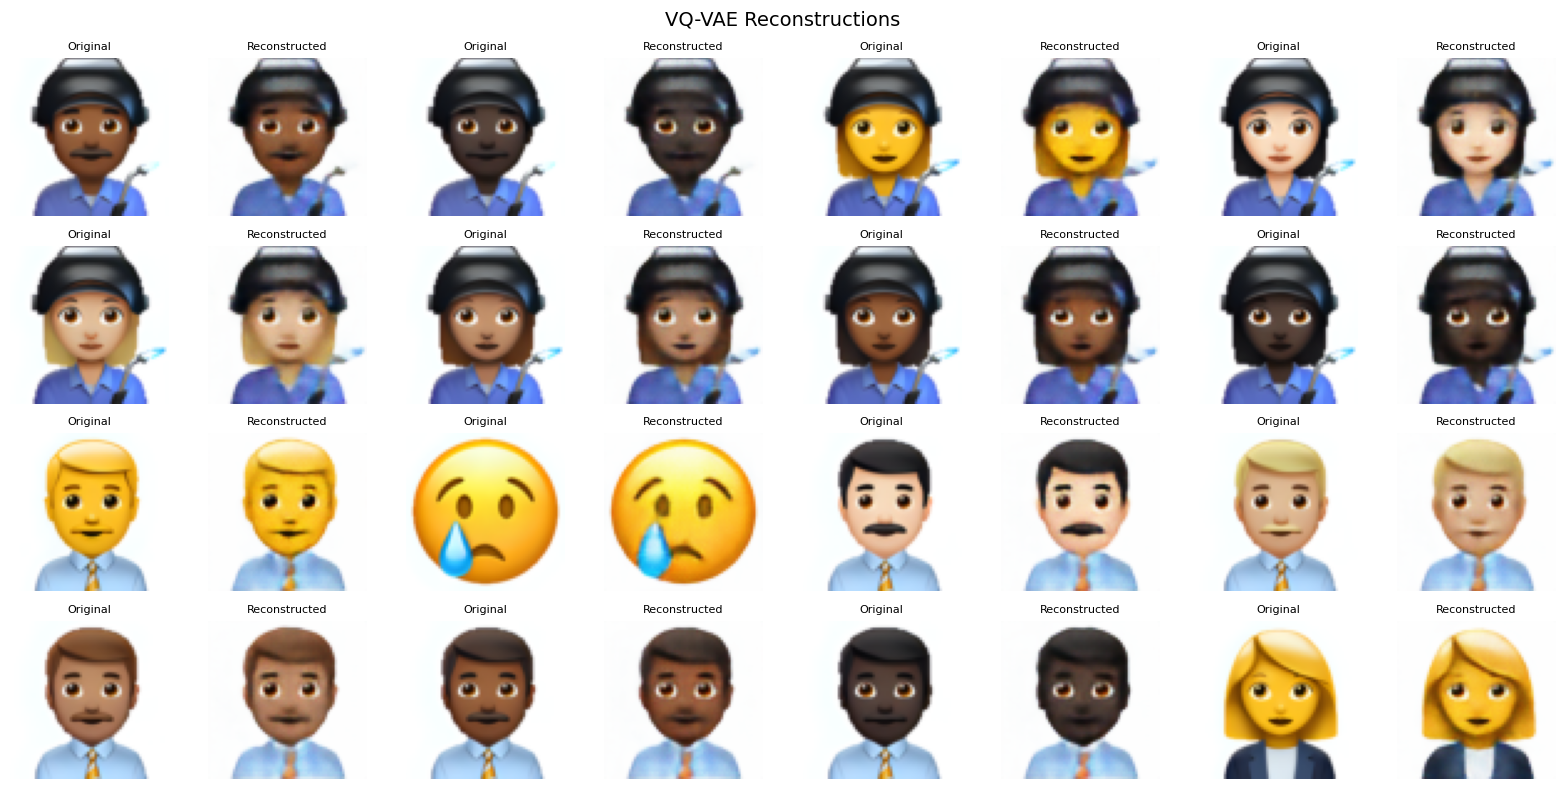

In [ ]:
# Visualize reconstructions
model.eval()
sample_batch = next(iter(val_loader))[:16].to(device)

with torch.no_grad():
    reconstructed, _, _, _ = model(sample_batch)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i in range(16):
    row = i // 4
    col = (i % 4) * 2

    # Original
    axes[row, col].imshow(sample_batch[i].cpu().permute(1, 2, 0))
    axes[row, col].set_title('Original', fontsize=8)
    axes[row, col].axis('off')

    # Reconstructed
    axes[row, col+1].imshow(reconstructed[i].cpu().permute(1, 2, 0))
    axes[row, col+1].set_title('Reconstructed', fontsize=8)
    axes[row, col+1].axis('off')

plt.suptitle('VQ-VAE Reconstructions', fontsize=14)
plt.tight_layout()
plt.show()

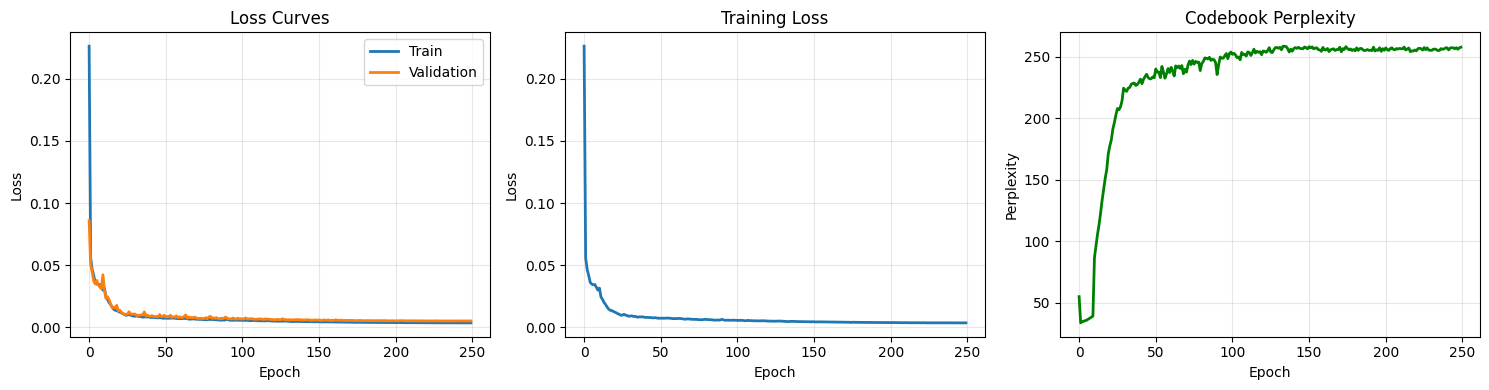

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train', linewidth=2)
plt.plot(val_losses, label='Validation', linewidth=2)
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_losses, linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(perplexities, linewidth=2, color='green')
plt.title('Codebook Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Load the trained VQ-VAE model
print("Loading trained VQ-VAE model...")

# Load the best model
model_path = "/content/vqvae_best (1).pt"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"VQ-VAE model not found at {model_path}. Please run Part A first.")

# Recreate model with same architecture
vqvae = ImprovedVQVAE(
    in_channels=3,
    hidden_dims=HIDDEN_DIMS,
    latent_dim=LATENT_DIM,
    num_embeddings=NUM_EMBEDDINGS,
    commitment_cost=COMMITMENT_COST,
    num_res_blocks=NUM_RES_BLOCKS,
    decay=EMA_DECAY,
    use_attention=True
).to(device)

# Load weights
vqvae.load_state_dict(torch.load(model_path, map_location=device))
vqvae.eval()

# Freeze VQ-VAE parameters
for param in vqvae.parameters():
    param.requires_grad = False

print(f"✅ VQ-VAE loaded successfully from {model_path}")
print(f"Model in evaluation mode with frozen parameters")

Loading trained VQ-VAE model...
✅ VQ-VAE loaded successfully from /content/vqvae_best (1).pt
Model in evaluation mode with frozen parameters


In [ ]:
# Extract discrete codes for training the prior
print("Extracting discrete codes from dataset...")

def extract_codes(model, loader, device):
    """Extract discrete codes from all images in the dataset"""
    model.eval()
    all_codes = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Encoding images"):
            batch = batch.to(device)
            # Get encoder output
            z = model.encoder(batch)
            # Get discrete codes directly from quantizer
            z_permuted = z.permute(0, 2, 3, 1).contiguous()
            z_flattened = z_permuted.view(-1, model.vq.embedding_dim)

            distances = (z_flattened.pow(2).sum(1, keepdim=True)
                        - 2 * z_flattened @ model.vq.embeddings.weight.t()
                        + model.vq.embeddings.weight.pow(2).sum(1, keepdim=True).t())

            indices = torch.argmin(distances, dim=1)
            # Reshape to spatial dimensions
            codes = indices.view(batch.shape[0], z.shape[2], z.shape[3])
            all_codes.append(codes.cpu())

    return torch.cat(all_codes, dim=0)

# Extract codes from training data
all_codes = extract_codes(vqvae, train_loader, device)
print(f"Extracted codes shape: {all_codes.shape}")
print(f"Code values range: [{all_codes.min().item()}, {all_codes.max().item()}]")
print(f"Unique codes used: {len(torch.unique(all_codes))}/{NUM_EMBEDDINGS}")

# Calculate spatial dimensions
latent_size = all_codes.shape[1]  # Should be 8 for 64x64 images
sequence_length = latent_size * latent_size
print(f"Latent spatial size: {latent_size}x{latent_size}")
print(f"Sequence length: {sequence_length}")

Extracting discrete codes from dataset...


Encoding images: 100%|██████████| 39/39 [06:55<00:00, 10.66s/it]

Extracted codes shape: torch.Size([2474, 16, 16])
Code values range: [0, 511]
Unique codes used: 487/512
Latent spatial size: 16x16
Sequence length: 256


In [ ]:
# Prepare dataset for transformer training
from torch.utils.data import TensorDataset

# Flatten spatial dimensions to create sequences
codes_flat = all_codes.view(all_codes.shape[0], -1)
print(f"Flattened codes shape: {codes_flat.shape}")

# Create dataset and dataloader
code_dataset = TensorDataset(codes_flat)
code_loader = DataLoader(
    code_dataset,
    batch_size=32,  # Smaller batch size for transformer
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Code dataset size: {len(code_dataset)}")
print(f"Number of batches: {len(code_loader)}")

Flattened codes shape: torch.Size([2474, 256])
Code dataset size: 2474
Number of batches: 78


In [ ]:
# Define Transformer components
import math

class CausalSelfAttention(nn.Module):
    """Multi-head self-attention with causal mask"""

    def __init__(self, embed_dim, num_heads, dropout=0.1, max_seq_len=256):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.dropout = dropout

        # Query, Key, Value projections
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        # Causal mask
        self.register_buffer(
            "mask",
            torch.tril(torch.ones(max_seq_len, max_seq_len)).view(
                1, 1, max_seq_len, max_seq_len
            )
        )

    def forward(self, x):
        B, T, C = x.shape

        # Calculate Q, K, V
        qkv = self.qkv(x)
        q, k, v = qkv.split(self.embed_dim, dim=2)

        # Reshape for multi-head attention
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        # Apply attention to values
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.resid_dropout(self.out_proj(y))

        return y

class TransformerBlock(nn.Module):
    """Transformer block with attention and MLP"""

    def __init__(self, embed_dim, num_heads, dropout=0.1, max_seq_len=256):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = CausalSelfAttention(embed_dim, num_heads, dropout, max_seq_len)
        self.ln2 = nn.LayerNorm(embed_dim)

        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [ ]:
# Complete Transformer Prior model
class TransformerPrior(nn.Module):
    """Autoregressive transformer for modeling code sequences"""

    def __init__(self, num_codes=512, seq_len=64, embed_dim=512,
                 num_heads=8, num_layers=8, dropout=0.1):
        super().__init__()

        self.num_codes = num_codes
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # Token and position embeddings
        self.tok_emb = nn.Embedding(num_codes + 1, embed_dim)  # +1 for potential padding
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        self.drop = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, dropout, seq_len)
            for _ in range(num_layers)
        ])

        # Final layer norm and output projection
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_codes, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.seq_len, f"Sequence length {T} exceeds maximum {self.seq_len}"

        # Token embeddings
        tok_emb = self.tok_emb(idx)

        # Position embeddings
        pos_emb = self.pos_emb[:, :T, :]

        # Combine embeddings
        x = self.drop(tok_emb + pos_emb)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final layer norm and projection
        x = self.ln_f(x)
        logits = self.head(x)

        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=None):
        """Generate new tokens autoregressively"""
        self.eval()

        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx if idx.size(1) <= self.seq_len else idx[:, -self.seq_len:]

            # Get predictions
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Apply top-k sampling
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Apply top-p (nucleus) sampling
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices_to_remove.scatter(
                    dim=-1, index=sorted_indices, src=sorted_indices_to_remove
                )
                logits[indices_to_remove] = -float('Inf')

            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

# Create transformer prior model
transformer_prior = TransformerPrior(
    num_codes=NUM_EMBEDDINGS,
    seq_len=sequence_length,
    embed_dim=512,
    num_heads=8,
    num_layers=8,
    dropout=0.1
).to(device)

total_params = sum(p.numel() for p in transformer_prior.parameters())
print(f"Transformer Prior parameters: {total_params:,}")

Transformer Prior parameters: 25,875,968


In [ ]:
# Setup training configuration for transformer
PRIOR_EPOCHS = 150
PRIOR_LR = 3e-4
PRIOR_BATCH_SIZE = 32
WARMUP_STEPS = 500

# Optimizer with weight decay
prior_optimizer = torch.optim.AdamW(
    transformer_prior.parameters(),
    lr=PRIOR_LR,
    weight_decay=0.01,
    betas=(0.9, 0.95)
)

# Cosine annealing with warmup
total_steps = len(code_loader) * PRIOR_EPOCHS

def get_lr(step, warmup_steps, total_steps, max_lr, min_lr=1e-5):
    """Learning rate schedule with warmup and cosine annealing"""
    if step < warmup_steps:
        return max_lr * step / warmup_steps
    elif step < total_steps:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
    else:
        return min_lr

print(f"Training configuration:")
print(f"  - Epochs: {PRIOR_EPOCHS}")
print(f"  - Learning rate: {PRIOR_LR}")
print(f"  - Warmup steps: {WARMUP_STEPS}")
print(f"  - Total steps: {total_steps}")

Training configuration:
  - Epochs: 150
  - Learning rate: 0.0003
  - Warmup steps: 500
  - Total steps: 11700


In [ ]:
# Define training functions for transformer prior
def train_transformer_epoch(model, loader, optimizer, device, global_step, warmup_steps, total_steps, max_lr):
    """Train transformer for one epoch"""
    model.train()
    total_loss = 0
    total_tokens = 0

    pbar = tqdm(loader, desc="Training Transformer")
    for batch_idx, (batch,) in enumerate(pbar):
        batch = batch.to(device)

        # Prepare input and target
        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        # Forward pass
        optimizer.zero_grad()
        logits, loss = model(inputs, targets)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update learning rate
        lr = get_lr(global_step, warmup_steps, total_steps, max_lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        optimizer.step()

        # Track metrics
        total_loss += loss.item() * batch.size(0)
        total_tokens += batch.numel()
        global_step += 1

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{lr:.6f}',
            'perplexity': f'{math.exp(loss.item()):.2f}'
        })

    avg_loss = total_loss / len(loader.dataset)
    perplexity = math.exp(avg_loss)

    return avg_loss, perplexity, global_step

@torch.no_grad()
def evaluate_transformer(model, loader, device):
    """Evaluate transformer on validation set"""
    model.eval()
    total_loss = 0

    for (batch,) in tqdm(loader, desc="Evaluating"):
        batch = batch.to(device)
        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        logits, loss = model(inputs, targets)
        total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(loader.dataset)
    perplexity = math.exp(avg_loss)

    return avg_loss, perplexity

In [ ]:
# Training loop for transformer prior
print("Starting Transformer Prior training...")

train_losses = []
train_perplexities = []
best_loss = float('inf')
global_step = 0

for epoch in range(PRIOR_EPOCHS):
    # Training
    avg_loss, perplexity, global_step = train_transformer_epoch(
        transformer_prior, code_loader, prior_optimizer,
        device, global_step, WARMUP_STEPS, total_steps, PRIOR_LR
    )

    train_losses.append(avg_loss)
    train_perplexities.append(perplexity)

    print(f"\nEpoch {epoch+1}/{PRIOR_EPOCHS}")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Perplexity: {perplexity:.2f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(transformer_prior.state_dict(),
                  os.path.join(SAVE_DIR, 'transformer_prior_best.pt'))
        print(f"  → New best model saved!")

    # Periodic checkpoints
    if (epoch + 1) % 25 == 0:
        torch.save(transformer_prior.state_dict(),
                  os.path.join(SAVE_DIR, f'transformer_prior_epoch_{epoch+1}.pt'))

# Save final model
torch.save(transformer_prior.state_dict(),
          os.path.join(SAVE_DIR, 'transformer_prior_final.pt'))

print("\n✅ Transformer Prior training complete!")
print(f"Best loss: {best_loss:.4f}")

Starting Transformer Prior training...


Training Transformer: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s, loss=4.6618, lr=0.000046, perplexity=105.83]



Epoch 1/150
  Loss: 5.6429
  Perplexity: 282.27
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=4.1717, lr=0.000093, perplexity=64.82]



Epoch 2/150
  Loss: 4.8143
  Perplexity: 123.26
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s, loss=3.9704, lr=0.000140, perplexity=53.00]



Epoch 3/150
  Loss: 4.2862
  Perplexity: 72.69
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=4.1980, lr=0.000187, perplexity=66.55]



Epoch 4/150
  Loss: 4.0695
  Perplexity: 58.53
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s, loss=4.0538, lr=0.000233, perplexity=57.61]



Epoch 5/150
  Loss: 3.9463
  Perplexity: 51.74
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s, loss=3.8230, lr=0.000280, perplexity=45.74]



Epoch 6/150
  Loss: 3.8500
  Perplexity: 47.00
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=3.7744, lr=0.000300, perplexity=43.57]



Epoch 7/150
  Loss: 3.7593
  Perplexity: 42.92
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s, loss=3.6967, lr=0.000300, perplexity=40.31]



Epoch 8/150
  Loss: 3.6624
  Perplexity: 38.95
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=3.3620, lr=0.000300, perplexity=28.85]



Epoch 9/150
  Loss: 3.5681
  Perplexity: 35.45
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=3.2944, lr=0.000300, perplexity=26.96]



Epoch 10/150
  Loss: 3.4781
  Perplexity: 32.40
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=3.3050, lr=0.000299, perplexity=27.25]



Epoch 11/150
  Loss: 3.3828
  Perplexity: 29.45
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s, loss=3.3296, lr=0.000299, perplexity=27.93]



Epoch 12/150
  Loss: 3.2940
  Perplexity: 26.95
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s, loss=3.2518, lr=0.000299, perplexity=25.84]



Epoch 13/150
  Loss: 3.2011
  Perplexity: 24.56
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=2.9760, lr=0.000298, perplexity=19.61]



Epoch 14/150
  Loss: 3.1072
  Perplexity: 22.36
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=3.0947, lr=0.000297, perplexity=22.08]



Epoch 15/150
  Loss: 3.0081
  Perplexity: 20.25
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=3.4143, lr=0.000297, perplexity=30.40]



Epoch 16/150
  Loss: 2.9062
  Perplexity: 18.29
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=2.9959, lr=0.000296, perplexity=20.00]



Epoch 17/150
  Loss: 2.8046
  Perplexity: 16.52
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=2.4021, lr=0.000295, perplexity=11.05]



Epoch 18/150
  Loss: 2.7002
  Perplexity: 14.88
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=3.0637, lr=0.000295, perplexity=21.41]



Epoch 19/150
  Loss: 2.5968
  Perplexity: 13.42
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s, loss=2.2220, lr=0.000294, perplexity=9.23]



Epoch 20/150
  Loss: 2.4886
  Perplexity: 12.04
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=2.5882, lr=0.000293, perplexity=13.31]



Epoch 21/150
  Loss: 2.3849
  Perplexity: 10.86
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=2.1794, lr=0.000292, perplexity=8.84]



Epoch 22/150
  Loss: 2.2771
  Perplexity: 9.75
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=2.0401, lr=0.000291, perplexity=7.69]



Epoch 23/150
  Loss: 2.1706
  Perplexity: 8.76
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=2.1115, lr=0.000289, perplexity=8.26]



Epoch 24/150
  Loss: 2.0665
  Perplexity: 7.90
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=2.0196, lr=0.000288, perplexity=7.54]



Epoch 25/150
  Loss: 1.9644
  Perplexity: 7.13
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=1.7192, lr=0.000287, perplexity=5.58]



Epoch 26/150
  Loss: 1.8628
  Perplexity: 6.44
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s, loss=2.0224, lr=0.000286, perplexity=7.56]



Epoch 27/150
  Loss: 1.7635
  Perplexity: 5.83
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s, loss=1.8783, lr=0.000284, perplexity=6.54]



Epoch 28/150
  Loss: 1.6717
  Perplexity: 5.32
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=1.8072, lr=0.000283, perplexity=6.09]



Epoch 29/150
  Loss: 1.5767
  Perplexity: 4.84
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=1.4152, lr=0.000281, perplexity=4.12]



Epoch 30/150
  Loss: 1.4898
  Perplexity: 4.44
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=1.3778, lr=0.000280, perplexity=3.97]



Epoch 31/150
  Loss: 1.4051
  Perplexity: 4.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=1.3342, lr=0.000278, perplexity=3.80]



Epoch 32/150
  Loss: 1.3271
  Perplexity: 3.77
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=1.4085, lr=0.000276, perplexity=4.09]



Epoch 33/150
  Loss: 1.2549
  Perplexity: 3.51
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=1.1267, lr=0.000274, perplexity=3.09]



Epoch 34/150
  Loss: 1.1843
  Perplexity: 3.27
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=1.1596, lr=0.000273, perplexity=3.19]



Epoch 35/150
  Loss: 1.1193
  Perplexity: 3.06
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.9949, lr=0.000271, perplexity=2.70]



Epoch 36/150
  Loss: 1.0611
  Perplexity: 2.89
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=1.0909, lr=0.000269, perplexity=2.98]



Epoch 37/150
  Loss: 1.0038
  Perplexity: 2.73
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=1.1220, lr=0.000267, perplexity=3.07]



Epoch 38/150
  Loss: 0.9481
  Perplexity: 2.58
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.9655, lr=0.000265, perplexity=2.63]



Epoch 39/150
  Loss: 0.9010
  Perplexity: 2.46
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.8550, lr=0.000263, perplexity=2.35]



Epoch 40/150
  Loss: 0.8575
  Perplexity: 2.36
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.8141, lr=0.000260, perplexity=2.26]



Epoch 41/150
  Loss: 0.8192
  Perplexity: 2.27
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.8245, lr=0.000258, perplexity=2.28]



Epoch 42/150
  Loss: 0.7803
  Perplexity: 2.18
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.7910, lr=0.000256, perplexity=2.21]



Epoch 43/150
  Loss: 0.7422
  Perplexity: 2.10
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.7485, lr=0.000254, perplexity=2.11]



Epoch 44/150
  Loss: 0.7095
  Perplexity: 2.03
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.6917, lr=0.000251, perplexity=2.00]



Epoch 45/150
  Loss: 0.6822
  Perplexity: 1.98
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.6578, lr=0.000249, perplexity=1.93]



Epoch 46/150
  Loss: 0.6515
  Perplexity: 1.92
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.7395, lr=0.000247, perplexity=2.09]



Epoch 47/150
  Loss: 0.6209
  Perplexity: 1.86
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.6419, lr=0.000244, perplexity=1.90]



Epoch 48/150
  Loss: 0.6004
  Perplexity: 1.82
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.5917, lr=0.000242, perplexity=1.81]



Epoch 49/150
  Loss: 0.5777
  Perplexity: 1.78
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.5702, lr=0.000239, perplexity=1.77]



Epoch 50/150
  Loss: 0.5534
  Perplexity: 1.74
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.5415, lr=0.000236, perplexity=1.72]



Epoch 51/150
  Loss: 0.5298
  Perplexity: 1.70
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.5329, lr=0.000234, perplexity=1.70]



Epoch 52/150
  Loss: 0.5119
  Perplexity: 1.67
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.5166, lr=0.000231, perplexity=1.68]



Epoch 53/150
  Loss: 0.4916
  Perplexity: 1.63
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.5128, lr=0.000228, perplexity=1.67]



Epoch 54/150
  Loss: 0.4787
  Perplexity: 1.61
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.4849, lr=0.000226, perplexity=1.62]



Epoch 55/150
  Loss: 0.4598
  Perplexity: 1.58
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.4851, lr=0.000223, perplexity=1.62]



Epoch 56/150
  Loss: 0.4446
  Perplexity: 1.56
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.4454, lr=0.000220, perplexity=1.56]



Epoch 57/150
  Loss: 0.4311
  Perplexity: 1.54
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.4411, lr=0.000217, perplexity=1.55]



Epoch 58/150
  Loss: 0.4125
  Perplexity: 1.51
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.4219, lr=0.000214, perplexity=1.52]



Epoch 59/150
  Loss: 0.3994
  Perplexity: 1.49
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.4405, lr=0.000211, perplexity=1.55]



Epoch 60/150
  Loss: 0.3860
  Perplexity: 1.47
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.3928, lr=0.000208, perplexity=1.48]



Epoch 61/150
  Loss: 0.3761
  Perplexity: 1.46
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s, loss=0.4311, lr=0.000205, perplexity=1.54]



Epoch 62/150
  Loss: 0.3641
  Perplexity: 1.44
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.3939, lr=0.000202, perplexity=1.48]



Epoch 63/150
  Loss: 0.3511
  Perplexity: 1.42
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.3819, lr=0.000199, perplexity=1.47]



Epoch 64/150
  Loss: 0.3397
  Perplexity: 1.40
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.3535, lr=0.000196, perplexity=1.42]



Epoch 65/150
  Loss: 0.3302
  Perplexity: 1.39
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.3655, lr=0.000193, perplexity=1.44]



Epoch 66/150
  Loss: 0.3224
  Perplexity: 1.38
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.3192, lr=0.000190, perplexity=1.38]



Epoch 67/150
  Loss: 0.3093
  Perplexity: 1.36
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.3391, lr=0.000187, perplexity=1.40]



Epoch 68/150
  Loss: 0.3020
  Perplexity: 1.35
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.3044, lr=0.000184, perplexity=1.36]



Epoch 69/150
  Loss: 0.2928
  Perplexity: 1.34
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.3221, lr=0.000181, perplexity=1.38]



Epoch 70/150
  Loss: 0.2834
  Perplexity: 1.33
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2939, lr=0.000178, perplexity=1.34]



Epoch 71/150
  Loss: 0.2764
  Perplexity: 1.32
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2951, lr=0.000175, perplexity=1.34]



Epoch 72/150
  Loss: 0.2689
  Perplexity: 1.31
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2851, lr=0.000172, perplexity=1.33]



Epoch 73/150
  Loss: 0.2605
  Perplexity: 1.30
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2573, lr=0.000168, perplexity=1.29]



Epoch 74/150
  Loss: 0.2523
  Perplexity: 1.29
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2782, lr=0.000165, perplexity=1.32]



Epoch 75/150
  Loss: 0.2450
  Perplexity: 1.28
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2390, lr=0.000162, perplexity=1.27]



Epoch 76/150
  Loss: 0.2384
  Perplexity: 1.27
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2548, lr=0.000159, perplexity=1.29]



Epoch 77/150
  Loss: 0.2314
  Perplexity: 1.26
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2359, lr=0.000156, perplexity=1.27]



Epoch 78/150
  Loss: 0.2255
  Perplexity: 1.25
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.2295, lr=0.000153, perplexity=1.26]



Epoch 79/150
  Loss: 0.2201
  Perplexity: 1.25
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.2385, lr=0.000149, perplexity=1.27]



Epoch 80/150
  Loss: 0.2137
  Perplexity: 1.24
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.09it/s, loss=0.2129, lr=0.000146, perplexity=1.24]



Epoch 81/150
  Loss: 0.2076
  Perplexity: 1.23
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s, loss=0.2064, lr=0.000143, perplexity=1.23]



Epoch 82/150
  Loss: 0.2031
  Perplexity: 1.23
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.11it/s, loss=0.1898, lr=0.000140, perplexity=1.21]



Epoch 83/150
  Loss: 0.1970
  Perplexity: 1.22
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1864, lr=0.000137, perplexity=1.20]



Epoch 84/150
  Loss: 0.1906
  Perplexity: 1.21
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1836, lr=0.000134, perplexity=1.20]



Epoch 85/150
  Loss: 0.1862
  Perplexity: 1.20
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.2000, lr=0.000130, perplexity=1.22]



Epoch 86/150
  Loss: 0.1824
  Perplexity: 1.20
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1783, lr=0.000127, perplexity=1.20]



Epoch 87/150
  Loss: 0.1769
  Perplexity: 1.19
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1814, lr=0.000124, perplexity=1.20]



Epoch 88/150
  Loss: 0.1733
  Perplexity: 1.19
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1634, lr=0.000121, perplexity=1.18]



Epoch 89/150
  Loss: 0.1681
  Perplexity: 1.18
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1698, lr=0.000118, perplexity=1.19]



Epoch 90/150
  Loss: 0.1638
  Perplexity: 1.18
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1601, lr=0.000115, perplexity=1.17]



Epoch 91/150
  Loss: 0.1593
  Perplexity: 1.17
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1822, lr=0.000112, perplexity=1.20]



Epoch 92/150
  Loss: 0.1550
  Perplexity: 1.17
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1549, lr=0.000109, perplexity=1.17]



Epoch 93/150
  Loss: 0.1526
  Perplexity: 1.16
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1437, lr=0.000106, perplexity=1.15]



Epoch 94/150
  Loss: 0.1480
  Perplexity: 1.16
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1363, lr=0.000103, perplexity=1.15]



Epoch 95/150
  Loss: 0.1449
  Perplexity: 1.16
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1593, lr=0.000100, perplexity=1.17]



Epoch 96/150
  Loss: 0.1405
  Perplexity: 1.15
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1333, lr=0.000097, perplexity=1.14]



Epoch 97/150
  Loss: 0.1371
  Perplexity: 1.15
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1238, lr=0.000094, perplexity=1.13]



Epoch 98/150
  Loss: 0.1340
  Perplexity: 1.14
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1442, lr=0.000091, perplexity=1.16]



Epoch 99/150
  Loss: 0.1292
  Perplexity: 1.14
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1467, lr=0.000088, perplexity=1.16]



Epoch 100/150
  Loss: 0.1288
  Perplexity: 1.14
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1216, lr=0.000086, perplexity=1.13]



Epoch 101/150
  Loss: 0.1249
  Perplexity: 1.13
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1225, lr=0.000083, perplexity=1.13]



Epoch 102/150
  Loss: 0.1214
  Perplexity: 1.13
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1346, lr=0.000080, perplexity=1.14]



Epoch 103/150
  Loss: 0.1191
  Perplexity: 1.13
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1188, lr=0.000077, perplexity=1.13]



Epoch 104/150
  Loss: 0.1170
  Perplexity: 1.12
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1348, lr=0.000075, perplexity=1.14]



Epoch 105/150
  Loss: 0.1141
  Perplexity: 1.12
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1095, lr=0.000072, perplexity=1.12]



Epoch 106/150
  Loss: 0.1115
  Perplexity: 1.12
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1016, lr=0.000070, perplexity=1.11]



Epoch 107/150
  Loss: 0.1089
  Perplexity: 1.12
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1100, lr=0.000067, perplexity=1.12]



Epoch 108/150
  Loss: 0.1067
  Perplexity: 1.11
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1043, lr=0.000065, perplexity=1.11]



Epoch 109/150
  Loss: 0.1038
  Perplexity: 1.11
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s, loss=0.1100, lr=0.000062, perplexity=1.12]



Epoch 110/150
  Loss: 0.1015
  Perplexity: 1.11
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.0958, lr=0.000060, perplexity=1.10]



Epoch 111/150
  Loss: 0.0998
  Perplexity: 1.10
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.1009, lr=0.000057, perplexity=1.11]



Epoch 112/150
  Loss: 0.0983
  Perplexity: 1.10
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s, loss=0.0989, lr=0.000055, perplexity=1.10]



Epoch 113/150
  Loss: 0.0962
  Perplexity: 1.10
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s, loss=0.0992, lr=0.000053, perplexity=1.10]



Epoch 114/150
  Loss: 0.0939
  Perplexity: 1.10
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0998, lr=0.000051, perplexity=1.10]



Epoch 115/150
  Loss: 0.0925
  Perplexity: 1.10
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.0967, lr=0.000048, perplexity=1.10]



Epoch 116/150
  Loss: 0.0909
  Perplexity: 1.10
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0939, lr=0.000046, perplexity=1.10]



Epoch 117/150
  Loss: 0.0883
  Perplexity: 1.09
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0781, lr=0.000044, perplexity=1.08]



Epoch 118/150
  Loss: 0.0869
  Perplexity: 1.09
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0831, lr=0.000042, perplexity=1.09]



Epoch 119/150
  Loss: 0.0851
  Perplexity: 1.09
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0857, lr=0.000040, perplexity=1.09]



Epoch 120/150
  Loss: 0.0843
  Perplexity: 1.09
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0828, lr=0.000038, perplexity=1.09]



Epoch 121/150
  Loss: 0.0825
  Perplexity: 1.09
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.0970, lr=0.000036, perplexity=1.10]



Epoch 122/150
  Loss: 0.0816
  Perplexity: 1.09
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.0739, lr=0.000035, perplexity=1.08]



Epoch 123/150
  Loss: 0.0805
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.0909, lr=0.000033, perplexity=1.10]



Epoch 124/150
  Loss: 0.0788
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.0681, lr=0.000031, perplexity=1.07]



Epoch 125/150
  Loss: 0.0777
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0734, lr=0.000030, perplexity=1.08]



Epoch 126/150
  Loss: 0.0772
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0763, lr=0.000028, perplexity=1.08]



Epoch 127/150
  Loss: 0.0756
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0740, lr=0.000026, perplexity=1.08]



Epoch 128/150
  Loss: 0.0748
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0787, lr=0.000025, perplexity=1.08]



Epoch 129/150
  Loss: 0.0734
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0844, lr=0.000024, perplexity=1.09]



Epoch 130/150
  Loss: 0.0730
  Perplexity: 1.08
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0714, lr=0.000022, perplexity=1.07]



Epoch 131/150
  Loss: 0.0718
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0650, lr=0.000021, perplexity=1.07]



Epoch 132/150
  Loss: 0.0715
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0751, lr=0.000020, perplexity=1.08]



Epoch 133/150
  Loss: 0.0701
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0763, lr=0.000019, perplexity=1.08]



Epoch 134/150
  Loss: 0.0700
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.0654, lr=0.000018, perplexity=1.07]



Epoch 135/150
  Loss: 0.0685
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s, loss=0.0584, lr=0.000017, perplexity=1.06]



Epoch 136/150
  Loss: 0.0685
  Perplexity: 1.07


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0690, lr=0.000016, perplexity=1.07]



Epoch 137/150
  Loss: 0.0681
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0655, lr=0.000015, perplexity=1.07]



Epoch 138/150
  Loss: 0.0672
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0639, lr=0.000014, perplexity=1.07]



Epoch 139/150
  Loss: 0.0665
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0768, lr=0.000013, perplexity=1.08]



Epoch 140/150
  Loss: 0.0663
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0762, lr=0.000013, perplexity=1.08]



Epoch 141/150
  Loss: 0.0657
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0608, lr=0.000012, perplexity=1.06]



Epoch 142/150
  Loss: 0.0654
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0660, lr=0.000012, perplexity=1.07]



Epoch 143/150
  Loss: 0.0641
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0634, lr=0.000011, perplexity=1.07]



Epoch 144/150
  Loss: 0.0642
  Perplexity: 1.07


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0668, lr=0.000011, perplexity=1.07]



Epoch 145/150
  Loss: 0.0643
  Perplexity: 1.07


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.05it/s, loss=0.0526, lr=0.000011, perplexity=1.05]



Epoch 146/150
  Loss: 0.0634
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0584, lr=0.000010, perplexity=1.06]



Epoch 147/150
  Loss: 0.0637
  Perplexity: 1.07


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0647, lr=0.000010, perplexity=1.07]



Epoch 148/150
  Loss: 0.0632
  Perplexity: 1.07
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0662, lr=0.000010, perplexity=1.07]



Epoch 149/150
  Loss: 0.0629
  Perplexity: 1.06
  → New best model saved!


Training Transformer: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s, loss=0.0654, lr=0.000010, perplexity=1.07]



Epoch 150/150
  Loss: 0.0630
  Perplexity: 1.06

✅ Transformer Prior training complete!
Best loss: 0.0629


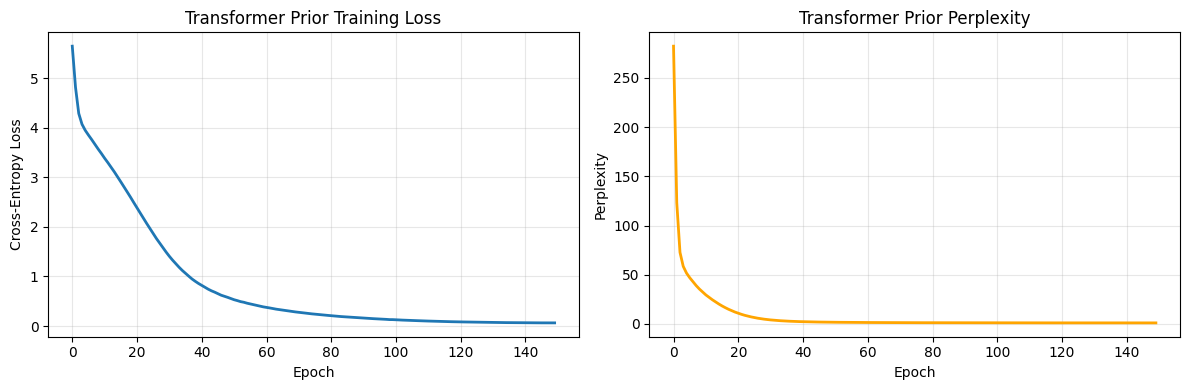

Final loss: 0.0630
Final perplexity: 1.06


In [ ]:
# Visualize training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, linewidth=2)
plt.title('Transformer Prior Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_perplexities, linewidth=2, color='orange')
plt.title('Transformer Prior Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss: {train_losses[-1]:.4f}")
print(f"Final perplexity: {train_perplexities[-1]:.2f}")

In [ ]:
# Define generation functions
@torch.no_grad()
def generate_emoji_codes(model, num_samples=16, temperature=1.0, top_k=50, top_p=0.95, device='cuda'):
    """Generate new emoji codes using the transformer prior"""
    model.eval()

    # Start with random tokens
    start_tokens = torch.randint(0, NUM_EMBEDDINGS, (num_samples, 1), device=device)

    # Generate full sequences
    generated = model.generate(
        start_tokens,
        max_new_tokens=sequence_length - 1,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p
    )

    # Reshape to spatial dimensions
    codes_2d = generated.reshape(num_samples, latent_size, latent_size)

    return codes_2d

@torch.no_grad()
def decode_codes_to_images(vqvae, codes, device='cuda'):
    """Decode discrete codes back to images using VQ-VAE decoder"""
    codes = codes.to(device)

    # Get embeddings
    quantized = vqvae.vq.embeddings(codes)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()

    # Decode to images
    images = vqvae.decoder(quantized)

    return images

def generate_and_visualize_emojis(num_samples=16, temperature=1.0, top_k=50):
    """Generate and visualize new emojis"""
    # Load best model
    transformer_prior.load_state_dict(
        torch.load(os.path.join(SAVE_DIR, 'transformer_prior_best.pt'))
    )

    # Generate codes
    generated_codes = generate_emoji_codes(
        transformer_prior, num_samples, temperature, top_k, device=device
    )

    # Decode to images
    generated_images = decode_codes_to_images(vqvae, generated_codes, device)

    return generated_images, generated_codes

Generating novel emojis...


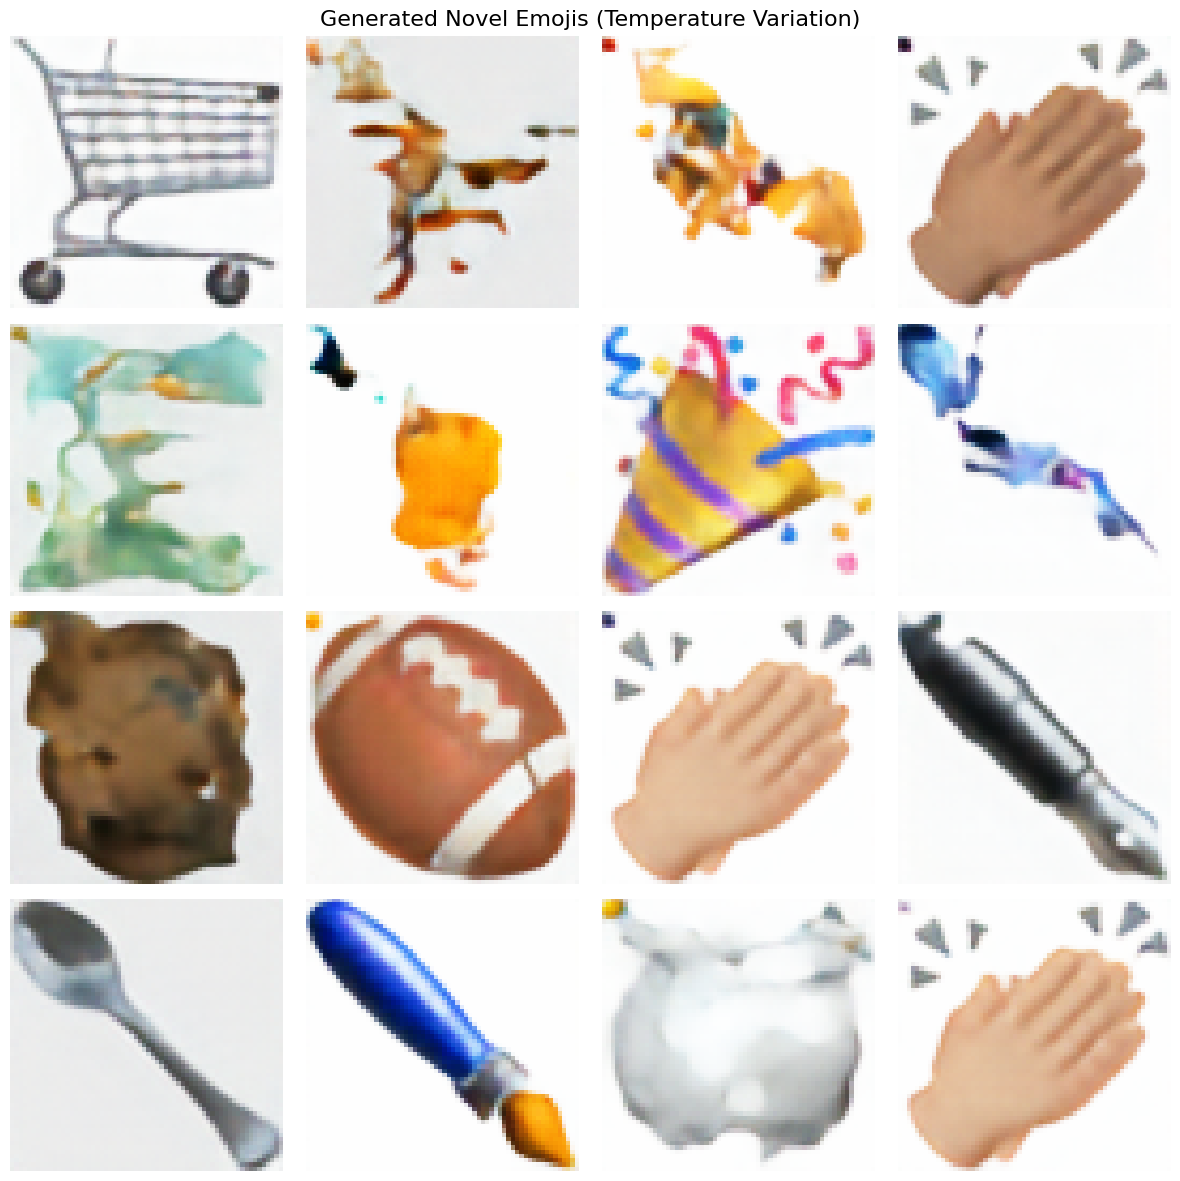

In [ ]:
print("Generating novel emojis...")

# Generate samples with different temperatures
temperatures = [0.7, 0.9, 1.0, 1.2]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, temp in enumerate(temperatures):
    generated_images, _ = generate_and_visualize_emojis(
        num_samples=4, temperature=temp, top_k=100
    )

    for j in range(4):
        ax = axes[i, j]
        img = generated_images[j].cpu().permute(1, 2, 0).numpy()
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'Temp={temp}', fontsize=12, rotation=0, labelpad=40)

plt.suptitle('Generated Novel Emojis (Temperature Variation)', fontsize=16)
plt.tight_layout()
plt.show()

Comparing real vs generated emojis...


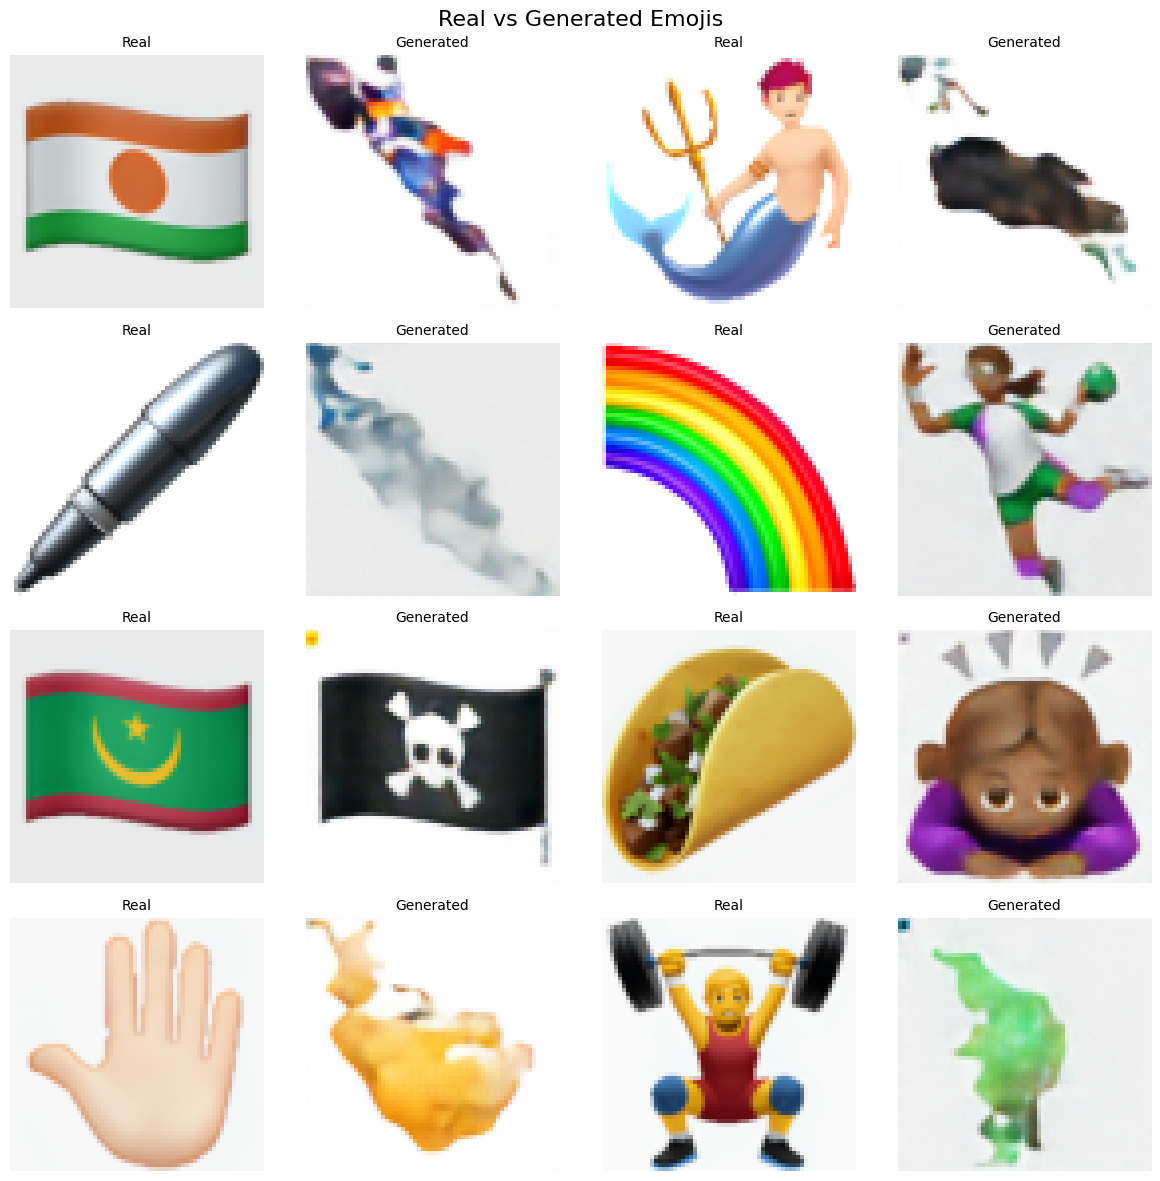

In [ ]:
print("Comparing real vs generated emojis...")

# Get real samples
real_batch = next(iter(train_loader))[:8].to(device)

# Generate new samples
generated_images, generated_codes = generate_and_visualize_emojis(
    num_samples=8, temperature=1.0, top_k=100
)

# Create comparison plot
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Real emoji
    ax_real = axes[i // 2, (i % 2) * 2]
    ax_real.imshow(real_batch[i].cpu().permute(1, 2, 0))
    ax_real.set_title('Real', fontsize=10)
    ax_real.axis('off')

    # Generated emoji
    ax_gen = axes[i // 2, (i % 2) * 2 + 1]
    ax_gen.imshow(generated_images[i].cpu().permute(1, 2, 0).numpy())
    ax_gen.set_title('Generated', fontsize=10)
    ax_gen.axis('off')

plt.suptitle('Real vs Generated Emojis', fontsize=16)
plt.tight_layout()
plt.show()

Analyzing generation diversity...


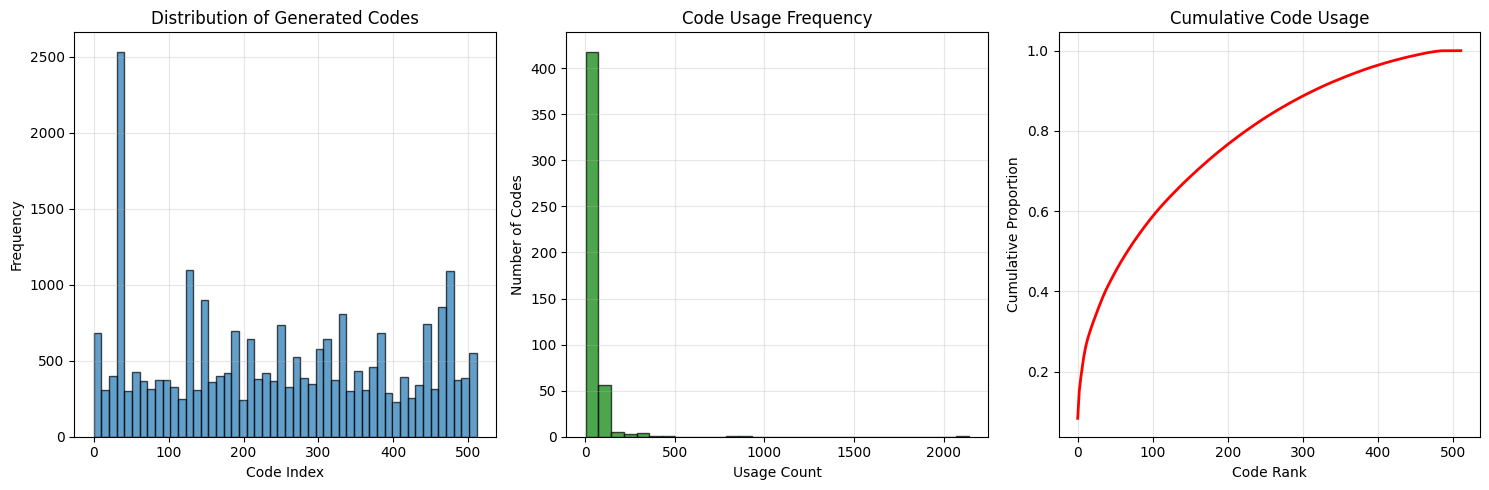

Unique codes used: 491/512
Code usage rate: 95.9%
Most used code: 40 (used 2141 times)
Average code usage: 52.14


In [ ]:
print("Analyzing generation diversity...")

# Generate many samples
num_test_samples = 100
all_generated_codes = []

for _ in range(5):  # Generate in batches
    codes = generate_emoji_codes(
        transformer_prior,
        num_samples=20,
        temperature=1.0,
        top_k=100,
        device=device
    )
    all_generated_codes.append(codes.cpu())

all_generated_codes = torch.cat(all_generated_codes, dim=0)
flat_codes = all_generated_codes.flatten().numpy()

# Analyze code usage
unique_codes = np.unique(flat_codes)
code_counts = np.bincount(flat_codes.astype(int), minlength=NUM_EMBEDDINGS)

plt.figure(figsize=(15, 5))

# Distribution of generated codes
plt.subplot(1, 3, 1)
plt.hist(flat_codes, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Generated Codes')
plt.xlabel('Code Index')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Code usage histogram
plt.subplot(1, 3, 2)
used_codes = code_counts[code_counts > 0]
plt.hist(used_codes, bins=30, edgecolor='black', alpha=0.7, color='green')
plt.title('Code Usage Frequency')
plt.xlabel('Usage Count')
plt.ylabel('Number of Codes')
plt.grid(True, alpha=0.3)

# Cumulative distribution
plt.subplot(1, 3, 3)
sorted_counts = np.sort(code_counts)[::-1]
cumsum = np.cumsum(sorted_counts) / np.sum(sorted_counts)
plt.plot(cumsum, linewidth=2, color='red')
plt.title('Cumulative Code Usage')
plt.xlabel('Code Rank')
plt.ylabel('Cumulative Proportion')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Unique codes used: {len(unique_codes)}/{NUM_EMBEDDINGS}")
print(f"Code usage rate: {len(unique_codes)/NUM_EMBEDDINGS*100:.1f}%")
print(f"Most used code: {np.argmax(code_counts)} (used {np.max(code_counts)} times)")
print(f"Average code usage: {np.mean(code_counts[code_counts > 0]):.2f}")

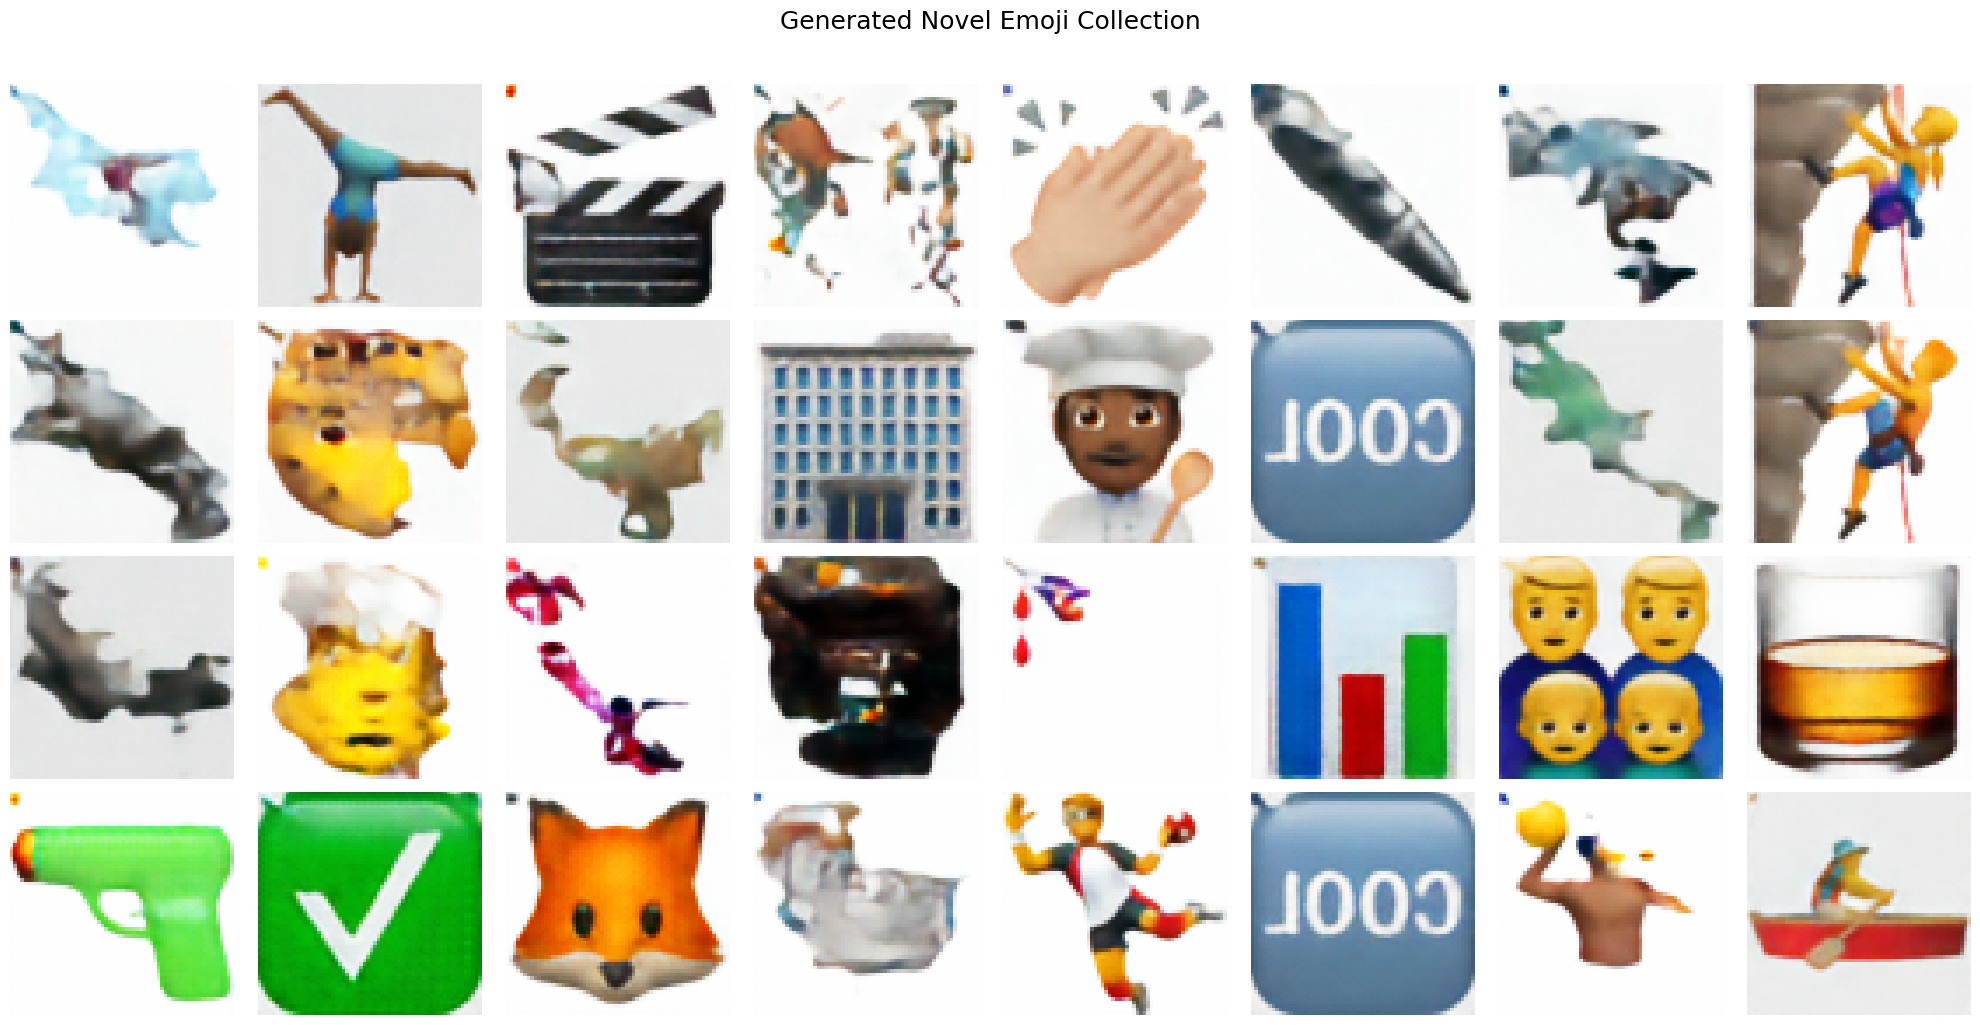

In [ ]:
# Generate diverse samples
num_showcase = 32
showcase_images, showcase_codes = generate_and_visualize_emojis(
    num_samples=num_showcase,
    temperature=1.0,
    top_k=100
)

# Create gallery
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()

for i in range(num_showcase):
    img = showcase_images[i].cpu().permute(1, 2, 0).numpy()
    axes[i].imshow(np.clip(img, 0, 1))
    axes[i].axis('off')

plt.suptitle('Generated Novel Emoji Collection', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()